In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import lightgbm as lgb
print("Lightgbm version:", lgb.__version__)

import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

Lightgbm version: 4.5.0


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "large"

In [4]:
# Parameters
fs_type = "fsv24"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 147
Categorical features: 8
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 219
Categorical Columns: 8


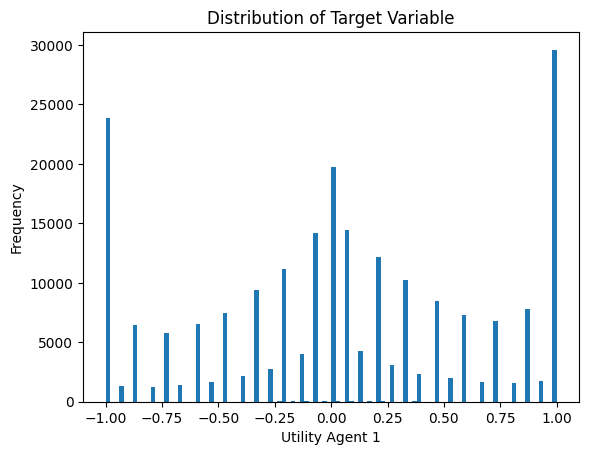

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.08
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.04
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.02
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.02 10000


In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters
    params = {
        'objective': "regression",
        'metric': 'rmse',
        'boosting': 'gbdt',
        ###################
        'num_leaves': 31,
        'max_depth': 12,
        'learning_rate': LEARNING_RATE,
        ###################
        'min_data_in_leaf': 100,
        'bagging_freq': 1,
        'bagging_fraction': 0.8,
        'feature_fraction': 0.5,
        'verbose': -1,
        'seed': 2112,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]
        
        # Create LightGBM datasets
        train_data = lgb.Dataset(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )
        val_data = lgb.Dataset(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )

        # Train the model
        model = lgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            valid_sets=[val_data],
            callbacks=[
                lgb.log_evaluation(period=100),
            ]
        )
        
        # Get feature importance for this fold
        feat_importance = pd.DataFrame({
            'feature': numerical_cols + categorical_cols,
            f'importance_f{fold}': model.feature_importance(importance_type='gain')
        })
        feat_importance_dfs.append(feat_importance)
        
        # Plot feature importance
        lgb.plot_importance(model, figsize=(10, 8), importance_type='gain', max_num_features=50)
        plt.title('Top 50 Features by Importance')
        plt.tight_layout()
        plt.show()
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(X_val[numerical_cols + categorical_cols])

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))
    
    return trained_models, oof, oof_scores, importance_df

Fold 1


[100]	valid_0's rmse: 0.491965


[200]	valid_0's rmse: 0.475901


[300]	valid_0's rmse: 0.467106


[400]	valid_0's rmse: 0.461306


[500]	valid_0's rmse: 0.457018


[600]	valid_0's rmse: 0.452684


[700]	valid_0's rmse: 0.44968


[800]	valid_0's rmse: 0.447179


[900]	valid_0's rmse: 0.445016


[1000]	valid_0's rmse: 0.443507


[1100]	valid_0's rmse: 0.441702


[1200]	valid_0's rmse: 0.440379


[1300]	valid_0's rmse: 0.439319


[1400]	valid_0's rmse: 0.438309


[1500]	valid_0's rmse: 0.437581


[1600]	valid_0's rmse: 0.436827


[1700]	valid_0's rmse: 0.436193


[1800]	valid_0's rmse: 0.435442


[1900]	valid_0's rmse: 0.434793


[2000]	valid_0's rmse: 0.434245


[2100]	valid_0's rmse: 0.433772


[2200]	valid_0's rmse: 0.433405


[2300]	valid_0's rmse: 0.432879


[2400]	valid_0's rmse: 0.432518


[2500]	valid_0's rmse: 0.432267


[2600]	valid_0's rmse: 0.431925


[2700]	valid_0's rmse: 0.43168


[2800]	valid_0's rmse: 0.431324


[2900]	valid_0's rmse: 0.431088


[3000]	valid_0's rmse: 0.430922


[3100]	valid_0's rmse: 0.430661


[3200]	valid_0's rmse: 0.430513


[3300]	valid_0's rmse: 0.43029


[3400]	valid_0's rmse: 0.430121


[3500]	valid_0's rmse: 0.429934


[3600]	valid_0's rmse: 0.429759


[3700]	valid_0's rmse: 0.429644


[3800]	valid_0's rmse: 0.429497


[3900]	valid_0's rmse: 0.429456


[4000]	valid_0's rmse: 0.429306


[4100]	valid_0's rmse: 0.42911


[4200]	valid_0's rmse: 0.428997


[4300]	valid_0's rmse: 0.428917


[4400]	valid_0's rmse: 0.428779


[4500]	valid_0's rmse: 0.42864


[4600]	valid_0's rmse: 0.428431


[4700]	valid_0's rmse: 0.428411


[4800]	valid_0's rmse: 0.428374


[4900]	valid_0's rmse: 0.428308


[5000]	valid_0's rmse: 0.428231


[5100]	valid_0's rmse: 0.428136


[5200]	valid_0's rmse: 0.428072


[5300]	valid_0's rmse: 0.428021


[5400]	valid_0's rmse: 0.427863


[5500]	valid_0's rmse: 0.427825


[5600]	valid_0's rmse: 0.427801


[5700]	valid_0's rmse: 0.427787


[5800]	valid_0's rmse: 0.427768


[5900]	valid_0's rmse: 0.427734


[6000]	valid_0's rmse: 0.427662


[6100]	valid_0's rmse: 0.427657


[6200]	valid_0's rmse: 0.427621


[6300]	valid_0's rmse: 0.427524


[6400]	valid_0's rmse: 0.427528


[6500]	valid_0's rmse: 0.427454


[6600]	valid_0's rmse: 0.427409


[6700]	valid_0's rmse: 0.427373


[6800]	valid_0's rmse: 0.427374


[6900]	valid_0's rmse: 0.427389


[7000]	valid_0's rmse: 0.427361


[7100]	valid_0's rmse: 0.42733


[7200]	valid_0's rmse: 0.427287


[7300]	valid_0's rmse: 0.427241


[7400]	valid_0's rmse: 0.427198


[7500]	valid_0's rmse: 0.427154


[7600]	valid_0's rmse: 0.427106


[7700]	valid_0's rmse: 0.427138


[7800]	valid_0's rmse: 0.427087


[7900]	valid_0's rmse: 0.427096


[8000]	valid_0's rmse: 0.42707


[8100]	valid_0's rmse: 0.427048


[8200]	valid_0's rmse: 0.427014


[8300]	valid_0's rmse: 0.427035


[8400]	valid_0's rmse: 0.426976


[8500]	valid_0's rmse: 0.42696


[8600]	valid_0's rmse: 0.426963


[8700]	valid_0's rmse: 0.426905


[8800]	valid_0's rmse: 0.426901


[8900]	valid_0's rmse: 0.426884


[9000]	valid_0's rmse: 0.426871


[9100]	valid_0's rmse: 0.426818


[9200]	valid_0's rmse: 0.426749


[9300]	valid_0's rmse: 0.426713


[9400]	valid_0's rmse: 0.426705


[9500]	valid_0's rmse: 0.426751


[9600]	valid_0's rmse: 0.426791


[9700]	valid_0's rmse: 0.426772


[9800]	valid_0's rmse: 0.426784


[9900]	valid_0's rmse: 0.426764


[10000]	valid_0's rmse: 0.426829


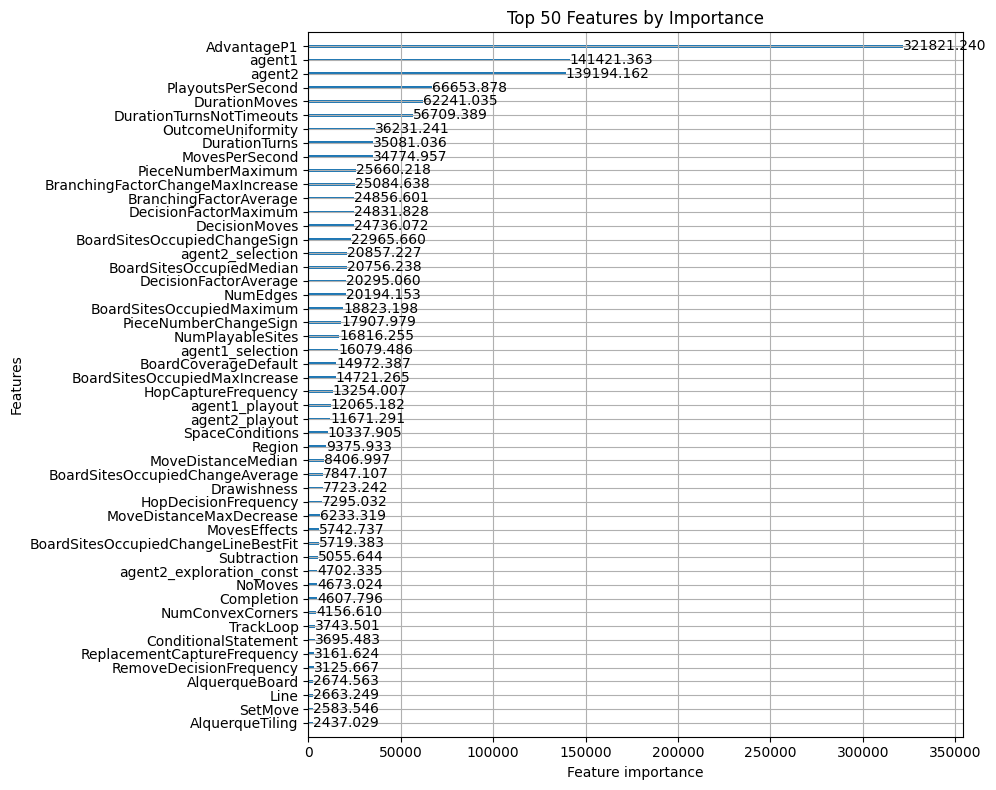

Fold 1 - RMSE: 0.4263650447970117
Fold 2


[100]	valid_0's rmse: 0.501712


[200]	valid_0's rmse: 0.480989


[300]	valid_0's rmse: 0.471286


[400]	valid_0's rmse: 0.46552


[500]	valid_0's rmse: 0.461302


[600]	valid_0's rmse: 0.458122


[700]	valid_0's rmse: 0.45562


[800]	valid_0's rmse: 0.453705


[900]	valid_0's rmse: 0.452039


[1000]	valid_0's rmse: 0.450335


[1100]	valid_0's rmse: 0.449212


[1200]	valid_0's rmse: 0.448215


[1300]	valid_0's rmse: 0.447369


[1400]	valid_0's rmse: 0.446597


[1500]	valid_0's rmse: 0.445804


[1600]	valid_0's rmse: 0.444985


[1700]	valid_0's rmse: 0.444197


[1800]	valid_0's rmse: 0.443697


[1900]	valid_0's rmse: 0.443306


[2000]	valid_0's rmse: 0.442756


[2100]	valid_0's rmse: 0.442353


[2200]	valid_0's rmse: 0.441978


[2300]	valid_0's rmse: 0.441557


[2400]	valid_0's rmse: 0.441229


[2500]	valid_0's rmse: 0.440851


[2600]	valid_0's rmse: 0.440522


[2700]	valid_0's rmse: 0.440232


[2800]	valid_0's rmse: 0.439983


[2900]	valid_0's rmse: 0.439701


[3000]	valid_0's rmse: 0.439617


[3100]	valid_0's rmse: 0.439358


[3200]	valid_0's rmse: 0.439229


[3300]	valid_0's rmse: 0.439023


[3400]	valid_0's rmse: 0.438749


[3500]	valid_0's rmse: 0.438636


[3600]	valid_0's rmse: 0.438462


[3700]	valid_0's rmse: 0.438339


[3800]	valid_0's rmse: 0.438221


[3900]	valid_0's rmse: 0.438092


[4000]	valid_0's rmse: 0.438011


[4100]	valid_0's rmse: 0.43782


[4200]	valid_0's rmse: 0.437751


[4300]	valid_0's rmse: 0.437696


[4400]	valid_0's rmse: 0.437385


[4500]	valid_0's rmse: 0.437237


[4600]	valid_0's rmse: 0.43715


[4700]	valid_0's rmse: 0.437067


[4800]	valid_0's rmse: 0.437008


[4900]	valid_0's rmse: 0.436911


[5000]	valid_0's rmse: 0.436857


[5100]	valid_0's rmse: 0.436747


[5200]	valid_0's rmse: 0.436711


[5300]	valid_0's rmse: 0.436625


[5400]	valid_0's rmse: 0.436583


[5500]	valid_0's rmse: 0.436605


[5600]	valid_0's rmse: 0.436506


[5700]	valid_0's rmse: 0.436362


[5800]	valid_0's rmse: 0.436282


[5900]	valid_0's rmse: 0.436222


[6000]	valid_0's rmse: 0.436242


[6100]	valid_0's rmse: 0.436114


[6200]	valid_0's rmse: 0.436085


[6300]	valid_0's rmse: 0.435984


[6400]	valid_0's rmse: 0.435846


[6500]	valid_0's rmse: 0.435834


[6600]	valid_0's rmse: 0.43577


[6700]	valid_0's rmse: 0.43573


[6800]	valid_0's rmse: 0.435688


[6900]	valid_0's rmse: 0.435645


[7000]	valid_0's rmse: 0.435514


[7100]	valid_0's rmse: 0.435488


[7200]	valid_0's rmse: 0.435406


[7300]	valid_0's rmse: 0.435337


[7400]	valid_0's rmse: 0.435257


[7500]	valid_0's rmse: 0.435143


[7600]	valid_0's rmse: 0.435054


[7700]	valid_0's rmse: 0.435057


[7800]	valid_0's rmse: 0.435048


[7900]	valid_0's rmse: 0.435003


[8000]	valid_0's rmse: 0.434935


[8100]	valid_0's rmse: 0.434949


[8200]	valid_0's rmse: 0.434928


[8300]	valid_0's rmse: 0.43486


[8400]	valid_0's rmse: 0.434778


[8500]	valid_0's rmse: 0.434791


[8600]	valid_0's rmse: 0.434839


[8700]	valid_0's rmse: 0.434705


[8800]	valid_0's rmse: 0.434641


[8900]	valid_0's rmse: 0.434617


[9000]	valid_0's rmse: 0.434596


[9100]	valid_0's rmse: 0.434583


[9200]	valid_0's rmse: 0.434487


[9300]	valid_0's rmse: 0.434477


[9400]	valid_0's rmse: 0.43442


[9500]	valid_0's rmse: 0.434446


[9600]	valid_0's rmse: 0.434442


[9700]	valid_0's rmse: 0.434425


[9800]	valid_0's rmse: 0.434448


[9900]	valid_0's rmse: 0.434408


[10000]	valid_0's rmse: 0.434385


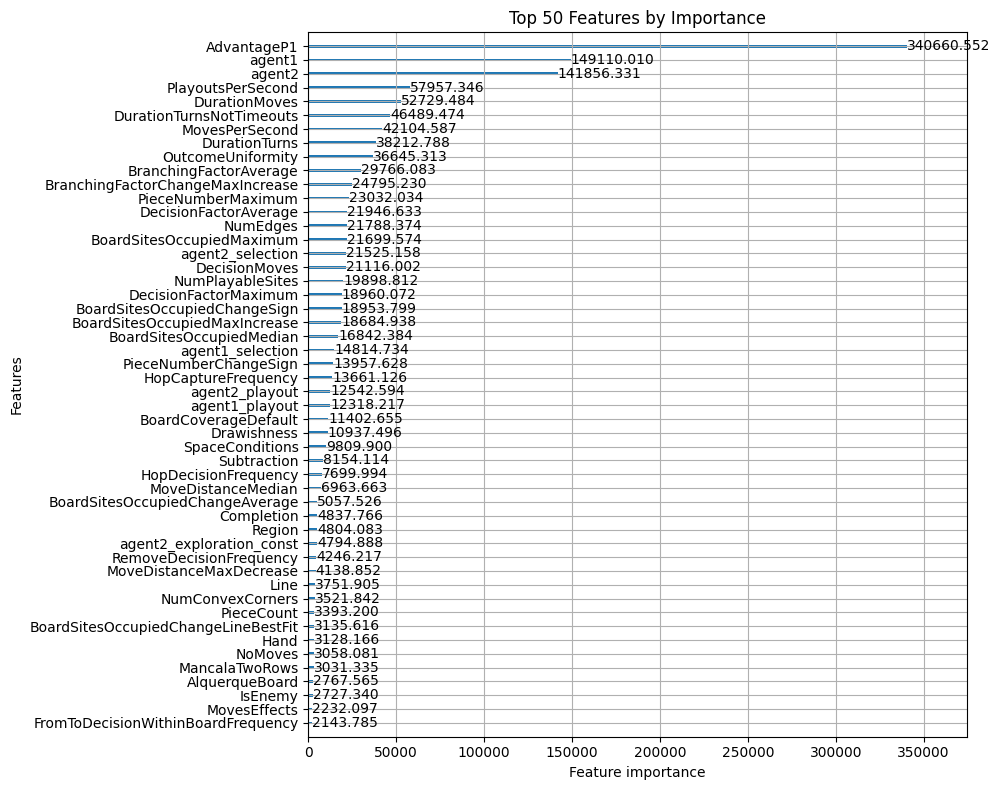

Fold 2 - RMSE: 0.4338850752313159
Fold 3


[100]	valid_0's rmse: 0.500199


[200]	valid_0's rmse: 0.469673


[300]	valid_0's rmse: 0.45679


[400]	valid_0's rmse: 0.450621


[500]	valid_0's rmse: 0.44695


[600]	valid_0's rmse: 0.443756


[700]	valid_0's rmse: 0.441132


[800]	valid_0's rmse: 0.438679


[900]	valid_0's rmse: 0.436942


[1000]	valid_0's rmse: 0.434936


[1100]	valid_0's rmse: 0.433212


[1200]	valid_0's rmse: 0.431785


[1300]	valid_0's rmse: 0.430746


[1400]	valid_0's rmse: 0.429996


[1500]	valid_0's rmse: 0.429181


[1600]	valid_0's rmse: 0.428377


[1700]	valid_0's rmse: 0.427702


[1800]	valid_0's rmse: 0.42696


[1900]	valid_0's rmse: 0.426378


[2000]	valid_0's rmse: 0.425761


[2100]	valid_0's rmse: 0.425278


[2200]	valid_0's rmse: 0.42485


[2300]	valid_0's rmse: 0.424404


[2400]	valid_0's rmse: 0.424021


[2500]	valid_0's rmse: 0.423605


[2600]	valid_0's rmse: 0.423344


[2700]	valid_0's rmse: 0.423016


[2800]	valid_0's rmse: 0.422819


[2900]	valid_0's rmse: 0.422448


[3000]	valid_0's rmse: 0.422248


[3100]	valid_0's rmse: 0.422008


[3200]	valid_0's rmse: 0.421822


[3300]	valid_0's rmse: 0.421456


[3400]	valid_0's rmse: 0.421268


[3500]	valid_0's rmse: 0.421146


[3600]	valid_0's rmse: 0.420976


[3700]	valid_0's rmse: 0.420681


[3800]	valid_0's rmse: 0.420577


[3900]	valid_0's rmse: 0.420369


[4000]	valid_0's rmse: 0.420234


[4100]	valid_0's rmse: 0.420067


[4200]	valid_0's rmse: 0.419965


[4300]	valid_0's rmse: 0.419937


[4400]	valid_0's rmse: 0.419862


[4500]	valid_0's rmse: 0.419723


[4600]	valid_0's rmse: 0.419633


[4700]	valid_0's rmse: 0.419543


[4800]	valid_0's rmse: 0.419418


[4900]	valid_0's rmse: 0.419309


[5000]	valid_0's rmse: 0.419189


[5100]	valid_0's rmse: 0.419143


[5200]	valid_0's rmse: 0.419109


[5300]	valid_0's rmse: 0.41899


[5400]	valid_0's rmse: 0.41891


[5500]	valid_0's rmse: 0.418782


[5600]	valid_0's rmse: 0.418669


[5700]	valid_0's rmse: 0.418595


[5800]	valid_0's rmse: 0.418469


[5900]	valid_0's rmse: 0.418461


[6000]	valid_0's rmse: 0.418355


[6100]	valid_0's rmse: 0.418207


[6200]	valid_0's rmse: 0.418106


[6300]	valid_0's rmse: 0.418095


[6400]	valid_0's rmse: 0.418034


[6500]	valid_0's rmse: 0.417931


[6600]	valid_0's rmse: 0.417991


[6700]	valid_0's rmse: 0.417961


[6800]	valid_0's rmse: 0.417948


[6900]	valid_0's rmse: 0.417861


[7000]	valid_0's rmse: 0.417799


[7100]	valid_0's rmse: 0.417755


[7200]	valid_0's rmse: 0.417649


[7300]	valid_0's rmse: 0.417619


[7400]	valid_0's rmse: 0.417525


[7500]	valid_0's rmse: 0.417389


[7600]	valid_0's rmse: 0.41732


[7700]	valid_0's rmse: 0.41727


[7800]	valid_0's rmse: 0.417242


[7900]	valid_0's rmse: 0.417196


[8000]	valid_0's rmse: 0.417131


[8100]	valid_0's rmse: 0.417077


[8200]	valid_0's rmse: 0.417004


[8300]	valid_0's rmse: 0.417027


[8400]	valid_0's rmse: 0.416992


[8500]	valid_0's rmse: 0.416951


[8600]	valid_0's rmse: 0.416948


[8700]	valid_0's rmse: 0.416914


[8800]	valid_0's rmse: 0.416884


[8900]	valid_0's rmse: 0.416836


[9000]	valid_0's rmse: 0.416839


[9100]	valid_0's rmse: 0.41677


[9200]	valid_0's rmse: 0.416669


[9300]	valid_0's rmse: 0.416636


[9400]	valid_0's rmse: 0.416579


[9500]	valid_0's rmse: 0.416586


[9600]	valid_0's rmse: 0.416565


[9700]	valid_0's rmse: 0.416517


[9800]	valid_0's rmse: 0.416447


[9900]	valid_0's rmse: 0.416419


[10000]	valid_0's rmse: 0.416422


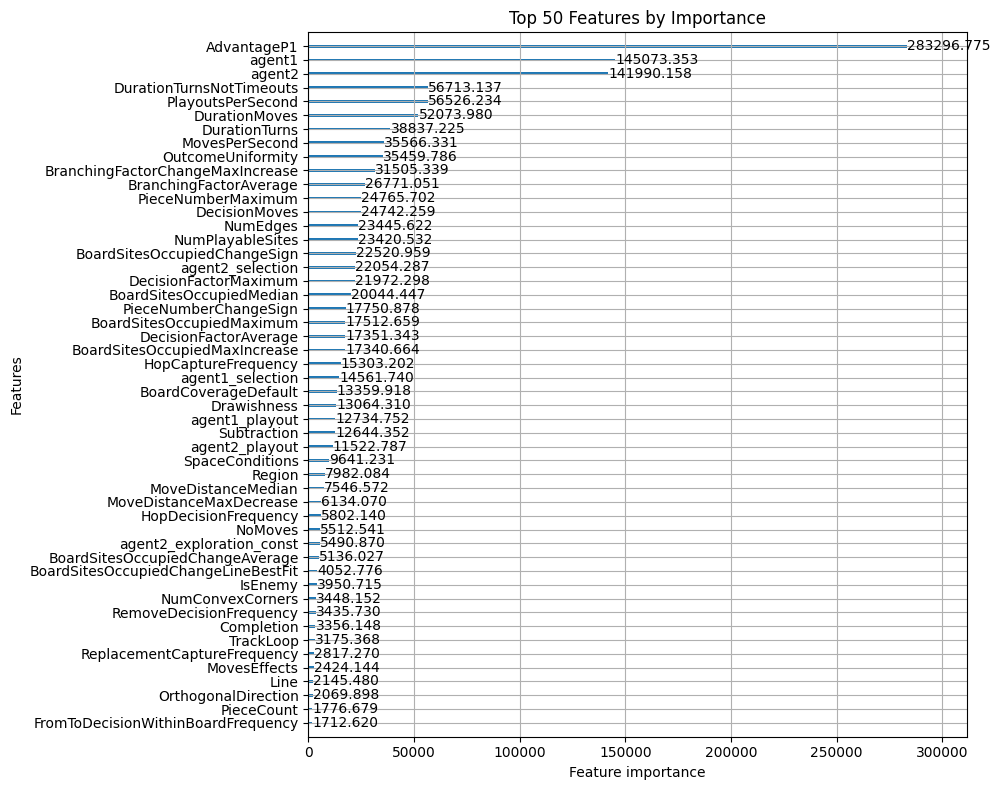

Fold 3 - RMSE: 0.41559417148410127
Fold 4


[100]	valid_0's rmse: 0.509168


[200]	valid_0's rmse: 0.48833


[300]	valid_0's rmse: 0.477676


[400]	valid_0's rmse: 0.470631


[500]	valid_0's rmse: 0.466016


[600]	valid_0's rmse: 0.462673


[700]	valid_0's rmse: 0.459272


[800]	valid_0's rmse: 0.456638


[900]	valid_0's rmse: 0.454671


[1000]	valid_0's rmse: 0.452686


[1100]	valid_0's rmse: 0.451281


[1200]	valid_0's rmse: 0.450086


[1300]	valid_0's rmse: 0.449029


[1400]	valid_0's rmse: 0.448047


[1500]	valid_0's rmse: 0.447152


[1600]	valid_0's rmse: 0.446495


[1700]	valid_0's rmse: 0.445629


[1800]	valid_0's rmse: 0.444708


[1900]	valid_0's rmse: 0.444144


[2000]	valid_0's rmse: 0.443513


[2100]	valid_0's rmse: 0.443068


[2200]	valid_0's rmse: 0.44255


[2300]	valid_0's rmse: 0.442159


[2400]	valid_0's rmse: 0.441642


[2500]	valid_0's rmse: 0.441176


[2600]	valid_0's rmse: 0.440846


[2700]	valid_0's rmse: 0.440328


[2800]	valid_0's rmse: 0.440073


[2900]	valid_0's rmse: 0.439737


[3000]	valid_0's rmse: 0.439405


[3100]	valid_0's rmse: 0.439151


[3200]	valid_0's rmse: 0.438794


[3300]	valid_0's rmse: 0.438607


[3400]	valid_0's rmse: 0.438459


[3500]	valid_0's rmse: 0.438294


[3600]	valid_0's rmse: 0.438052


[3700]	valid_0's rmse: 0.43796


[3800]	valid_0's rmse: 0.437804


[3900]	valid_0's rmse: 0.43762


[4000]	valid_0's rmse: 0.437502


[4100]	valid_0's rmse: 0.437297


[4200]	valid_0's rmse: 0.437106


[4300]	valid_0's rmse: 0.436938


[4400]	valid_0's rmse: 0.436827


[4500]	valid_0's rmse: 0.436756


[4600]	valid_0's rmse: 0.43661


[4700]	valid_0's rmse: 0.436517


[4800]	valid_0's rmse: 0.436328


[4900]	valid_0's rmse: 0.436153


[5000]	valid_0's rmse: 0.436007


[5100]	valid_0's rmse: 0.435876


[5200]	valid_0's rmse: 0.435691


[5300]	valid_0's rmse: 0.435641


[5400]	valid_0's rmse: 0.435609


[5500]	valid_0's rmse: 0.435473


[5600]	valid_0's rmse: 0.435379


[5700]	valid_0's rmse: 0.43529


[5800]	valid_0's rmse: 0.435202


[5900]	valid_0's rmse: 0.435119


[6000]	valid_0's rmse: 0.435014


[6100]	valid_0's rmse: 0.434935


[6200]	valid_0's rmse: 0.434915


[6300]	valid_0's rmse: 0.434874


[6400]	valid_0's rmse: 0.434816


[6500]	valid_0's rmse: 0.434793


[6600]	valid_0's rmse: 0.434719


[6700]	valid_0's rmse: 0.434656


[6800]	valid_0's rmse: 0.434611


[6900]	valid_0's rmse: 0.434617


[7000]	valid_0's rmse: 0.43454


[7100]	valid_0's rmse: 0.434526


[7200]	valid_0's rmse: 0.434442


[7300]	valid_0's rmse: 0.434352


[7400]	valid_0's rmse: 0.434292


[7500]	valid_0's rmse: 0.43419


[7600]	valid_0's rmse: 0.434116


[7700]	valid_0's rmse: 0.434003


[7800]	valid_0's rmse: 0.433984


[7900]	valid_0's rmse: 0.43399


[8000]	valid_0's rmse: 0.433934


[8100]	valid_0's rmse: 0.433997


[8200]	valid_0's rmse: 0.433993


[8300]	valid_0's rmse: 0.43399


[8400]	valid_0's rmse: 0.433966


[8500]	valid_0's rmse: 0.433899


[8600]	valid_0's rmse: 0.433856


[8700]	valid_0's rmse: 0.433836


[8800]	valid_0's rmse: 0.433755


[8900]	valid_0's rmse: 0.433743


[9000]	valid_0's rmse: 0.433698


[9100]	valid_0's rmse: 0.433706


[9200]	valid_0's rmse: 0.433648


[9300]	valid_0's rmse: 0.433684


[9400]	valid_0's rmse: 0.433647


[9500]	valid_0's rmse: 0.4336


[9600]	valid_0's rmse: 0.433583


[9700]	valid_0's rmse: 0.433569


[9800]	valid_0's rmse: 0.433565


[9900]	valid_0's rmse: 0.433525


[10000]	valid_0's rmse: 0.433537


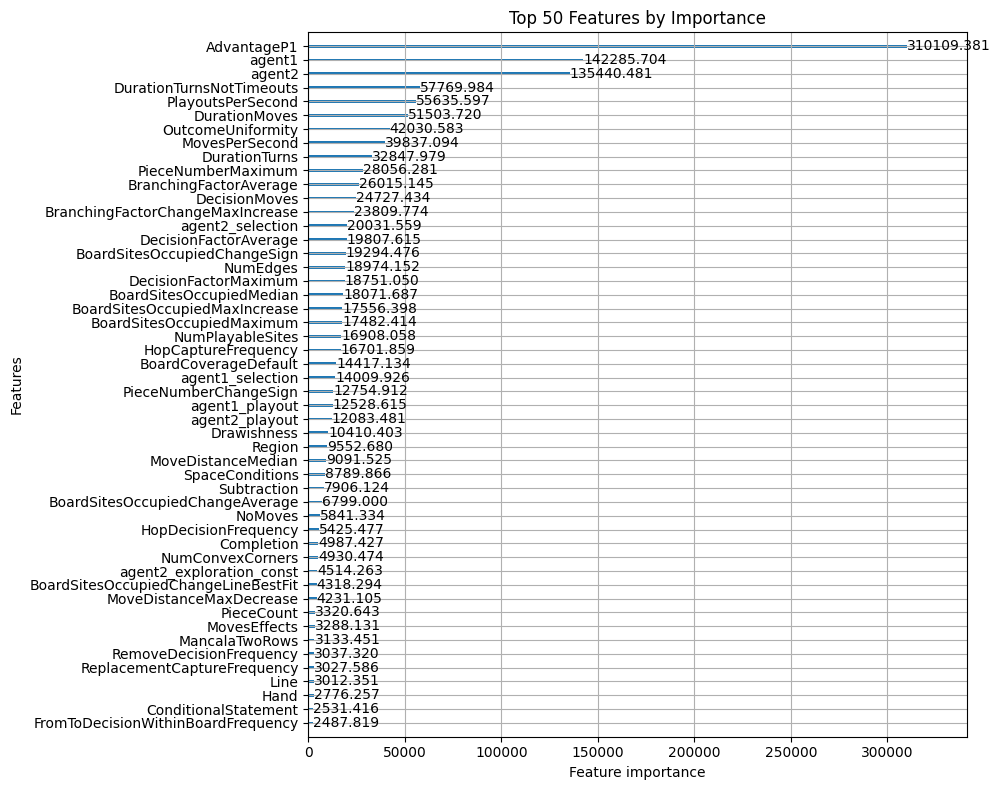

Fold 4 - RMSE: 0.43281518118558293
Fold 5


[100]	valid_0's rmse: 0.482759


[200]	valid_0's rmse: 0.45971


[300]	valid_0's rmse: 0.446775


[400]	valid_0's rmse: 0.438605


[500]	valid_0's rmse: 0.433125


[600]	valid_0's rmse: 0.428678


[700]	valid_0's rmse: 0.425109


[800]	valid_0's rmse: 0.422397


[900]	valid_0's rmse: 0.420195


[1000]	valid_0's rmse: 0.418863


[1100]	valid_0's rmse: 0.417085


[1200]	valid_0's rmse: 0.415826


[1300]	valid_0's rmse: 0.414846


[1400]	valid_0's rmse: 0.41362


[1500]	valid_0's rmse: 0.412737


[1600]	valid_0's rmse: 0.411864


[1700]	valid_0's rmse: 0.411135


[1800]	valid_0's rmse: 0.410384


[1900]	valid_0's rmse: 0.409749


[2000]	valid_0's rmse: 0.409124


[2100]	valid_0's rmse: 0.408553


[2200]	valid_0's rmse: 0.408094


[2300]	valid_0's rmse: 0.407665


[2400]	valid_0's rmse: 0.407257


[2500]	valid_0's rmse: 0.406932


[2600]	valid_0's rmse: 0.406604


[2700]	valid_0's rmse: 0.406286


[2800]	valid_0's rmse: 0.405921


[2900]	valid_0's rmse: 0.405615


[3000]	valid_0's rmse: 0.405411


[3100]	valid_0's rmse: 0.405201


[3200]	valid_0's rmse: 0.405023


[3300]	valid_0's rmse: 0.404737


[3400]	valid_0's rmse: 0.4045


[3500]	valid_0's rmse: 0.40431


[3600]	valid_0's rmse: 0.404134


[3700]	valid_0's rmse: 0.404079


[3800]	valid_0's rmse: 0.403964


[3900]	valid_0's rmse: 0.403716


[4000]	valid_0's rmse: 0.40361


[4100]	valid_0's rmse: 0.403438


[4200]	valid_0's rmse: 0.403305


[4300]	valid_0's rmse: 0.403181


[4400]	valid_0's rmse: 0.403059


[4500]	valid_0's rmse: 0.402983


[4600]	valid_0's rmse: 0.402831


[4700]	valid_0's rmse: 0.402696


[4800]	valid_0's rmse: 0.402547


[4900]	valid_0's rmse: 0.402502


[5000]	valid_0's rmse: 0.402446


[5100]	valid_0's rmse: 0.402372


[5200]	valid_0's rmse: 0.402341


[5300]	valid_0's rmse: 0.4023


[5400]	valid_0's rmse: 0.402184


[5500]	valid_0's rmse: 0.402074


[5600]	valid_0's rmse: 0.402008


[5700]	valid_0's rmse: 0.401954


[5800]	valid_0's rmse: 0.401908


[5900]	valid_0's rmse: 0.401839


[6000]	valid_0's rmse: 0.401788


[6100]	valid_0's rmse: 0.401673


[6200]	valid_0's rmse: 0.401584


[6300]	valid_0's rmse: 0.401561


[6400]	valid_0's rmse: 0.401505


[6500]	valid_0's rmse: 0.401409


[6600]	valid_0's rmse: 0.401391


[6700]	valid_0's rmse: 0.401395


[6800]	valid_0's rmse: 0.401329


[6900]	valid_0's rmse: 0.401297


[7000]	valid_0's rmse: 0.401244


[7100]	valid_0's rmse: 0.401189


[7200]	valid_0's rmse: 0.401168


[7300]	valid_0's rmse: 0.401142


[7400]	valid_0's rmse: 0.401091


[7500]	valid_0's rmse: 0.401072


[7600]	valid_0's rmse: 0.401042


[7700]	valid_0's rmse: 0.400967


[7800]	valid_0's rmse: 0.400941


[7900]	valid_0's rmse: 0.400892


[8000]	valid_0's rmse: 0.400803


[8100]	valid_0's rmse: 0.40076


[8200]	valid_0's rmse: 0.400701


[8300]	valid_0's rmse: 0.400721


[8400]	valid_0's rmse: 0.40071


[8500]	valid_0's rmse: 0.400719


[8600]	valid_0's rmse: 0.400727


[8700]	valid_0's rmse: 0.400716


[8800]	valid_0's rmse: 0.400664


[8900]	valid_0's rmse: 0.400682


[9000]	valid_0's rmse: 0.400653


[9100]	valid_0's rmse: 0.400662


[9200]	valid_0's rmse: 0.400662


[9300]	valid_0's rmse: 0.400675


[9400]	valid_0's rmse: 0.40073


[9500]	valid_0's rmse: 0.400724


[9600]	valid_0's rmse: 0.400713


[9700]	valid_0's rmse: 0.400674


[9800]	valid_0's rmse: 0.400695


[9900]	valid_0's rmse: 0.400705


[10000]	valid_0's rmse: 0.400709


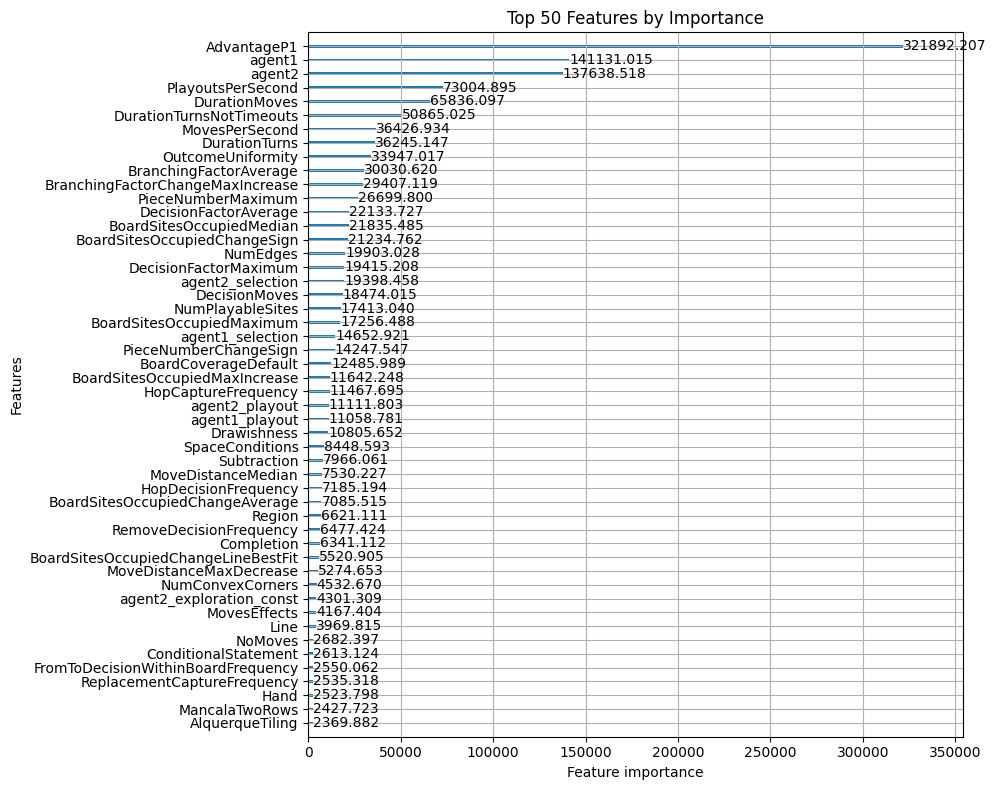

Fold 5 - RMSE: 0.40016197371731843
List of oof scores: [0.4263650447970117, 0.4338850752313159, 0.41559417148410127, 0.43281518118558293, 0.40016197371731843]
Average oof score: 0.4217642892830661


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv1.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.471962


[200]	valid_0's rmse: 0.454077


[300]	valid_0's rmse: 0.444998


[400]	valid_0's rmse: 0.439524


[500]	valid_0's rmse: 0.435659


[600]	valid_0's rmse: 0.433261


[700]	valid_0's rmse: 0.430605


[800]	valid_0's rmse: 0.4283


[900]	valid_0's rmse: 0.426387


[1000]	valid_0's rmse: 0.425146


[1100]	valid_0's rmse: 0.424116


[1200]	valid_0's rmse: 0.42314


[1300]	valid_0's rmse: 0.422265


[1400]	valid_0's rmse: 0.421402


[1500]	valid_0's rmse: 0.420795


[1600]	valid_0's rmse: 0.420172


[1700]	valid_0's rmse: 0.41955


[1800]	valid_0's rmse: 0.419075


[1900]	valid_0's rmse: 0.418569


[2000]	valid_0's rmse: 0.418244


[2100]	valid_0's rmse: 0.417907


[2200]	valid_0's rmse: 0.417535


[2300]	valid_0's rmse: 0.417294


[2400]	valid_0's rmse: 0.417015


[2500]	valid_0's rmse: 0.41685


[2600]	valid_0's rmse: 0.416523


[2700]	valid_0's rmse: 0.41628


[2800]	valid_0's rmse: 0.416004


[2900]	valid_0's rmse: 0.415725


[3000]	valid_0's rmse: 0.415496


[3100]	valid_0's rmse: 0.415335


[3200]	valid_0's rmse: 0.415167


[3300]	valid_0's rmse: 0.415021


[3400]	valid_0's rmse: 0.414854


[3500]	valid_0's rmse: 0.414618


[3600]	valid_0's rmse: 0.414415


[3700]	valid_0's rmse: 0.414191


[3800]	valid_0's rmse: 0.414023


[3900]	valid_0's rmse: 0.413877


[4000]	valid_0's rmse: 0.413708


[4100]	valid_0's rmse: 0.413663


[4200]	valid_0's rmse: 0.41356


[4300]	valid_0's rmse: 0.413387


[4400]	valid_0's rmse: 0.413231


[4500]	valid_0's rmse: 0.413158


[4600]	valid_0's rmse: 0.41309


[4700]	valid_0's rmse: 0.413038


[4800]	valid_0's rmse: 0.412925


[4900]	valid_0's rmse: 0.412855


[5000]	valid_0's rmse: 0.412779


[5100]	valid_0's rmse: 0.412696


[5200]	valid_0's rmse: 0.412584


[5300]	valid_0's rmse: 0.41253


[5400]	valid_0's rmse: 0.412542


[5500]	valid_0's rmse: 0.412499


[5600]	valid_0's rmse: 0.412373


[5700]	valid_0's rmse: 0.412337


[5800]	valid_0's rmse: 0.41232


[5900]	valid_0's rmse: 0.412216


[6000]	valid_0's rmse: 0.412209


[6100]	valid_0's rmse: 0.41216


[6200]	valid_0's rmse: 0.412074


[6300]	valid_0's rmse: 0.412024


[6400]	valid_0's rmse: 0.411993


[6500]	valid_0's rmse: 0.411872


[6600]	valid_0's rmse: 0.411823


[6700]	valid_0's rmse: 0.411734


[6800]	valid_0's rmse: 0.411709


[6900]	valid_0's rmse: 0.411645


[7000]	valid_0's rmse: 0.411575


[7100]	valid_0's rmse: 0.411484


[7200]	valid_0's rmse: 0.411422


[7300]	valid_0's rmse: 0.411404


[7400]	valid_0's rmse: 0.41134


[7500]	valid_0's rmse: 0.411287


[7600]	valid_0's rmse: 0.411208


[7700]	valid_0's rmse: 0.41118


[7800]	valid_0's rmse: 0.411088


[7900]	valid_0's rmse: 0.411076


[8000]	valid_0's rmse: 0.41104


[8100]	valid_0's rmse: 0.411013


[8200]	valid_0's rmse: 0.410999


[8300]	valid_0's rmse: 0.410971


[8400]	valid_0's rmse: 0.410937


[8500]	valid_0's rmse: 0.410877


[8600]	valid_0's rmse: 0.410859


[8700]	valid_0's rmse: 0.410847


[8800]	valid_0's rmse: 0.410849


[8900]	valid_0's rmse: 0.410732


[9000]	valid_0's rmse: 0.410759


[9100]	valid_0's rmse: 0.410731


[9200]	valid_0's rmse: 0.410707


[9300]	valid_0's rmse: 0.41063


[9400]	valid_0's rmse: 0.410572


[9500]	valid_0's rmse: 0.410523


[9600]	valid_0's rmse: 0.410393


[9700]	valid_0's rmse: 0.410406


[9800]	valid_0's rmse: 0.410399


[9900]	valid_0's rmse: 0.410336


[10000]	valid_0's rmse: 0.410247


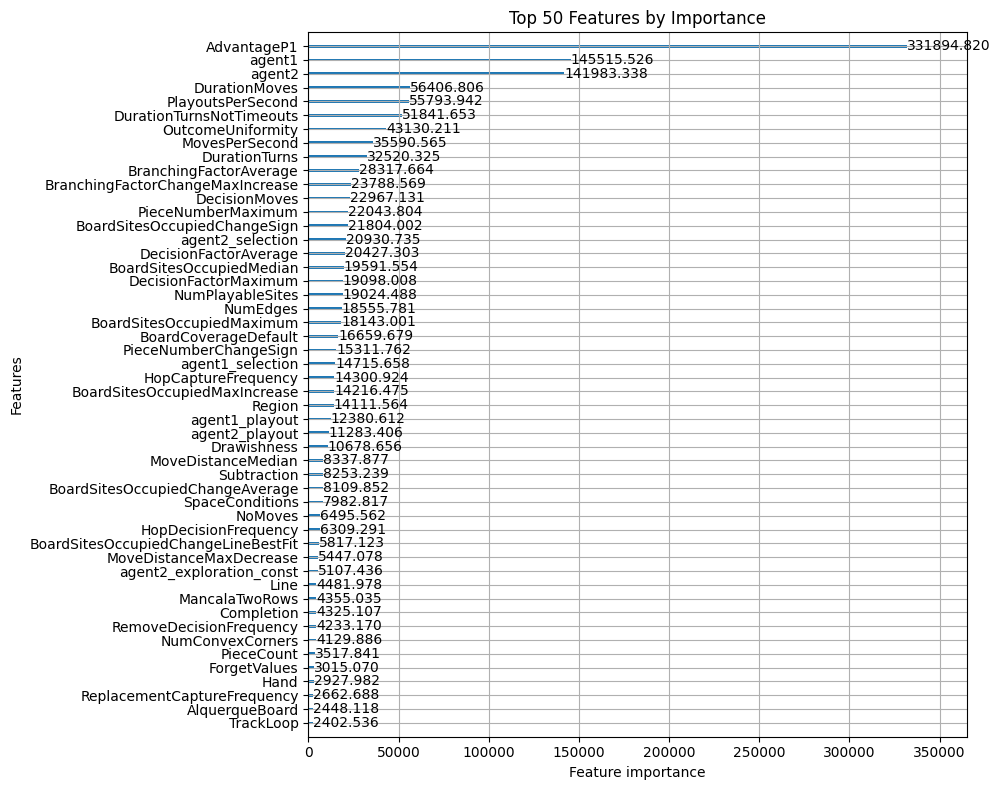

Fold 1 - RMSE: 0.40973817440785737
Fold 2


[100]	valid_0's rmse: 0.456603


[200]	valid_0's rmse: 0.437157


[300]	valid_0's rmse: 0.428343


[400]	valid_0's rmse: 0.424024


[500]	valid_0's rmse: 0.421348


[600]	valid_0's rmse: 0.41892


[700]	valid_0's rmse: 0.417216


[800]	valid_0's rmse: 0.415745


[900]	valid_0's rmse: 0.414616


[1000]	valid_0's rmse: 0.413479


[1100]	valid_0's rmse: 0.412452


[1200]	valid_0's rmse: 0.411792


[1300]	valid_0's rmse: 0.411177


[1400]	valid_0's rmse: 0.410383


[1500]	valid_0's rmse: 0.409662


[1600]	valid_0's rmse: 0.40916


[1700]	valid_0's rmse: 0.408711


[1800]	valid_0's rmse: 0.408417


[1900]	valid_0's rmse: 0.407981


[2000]	valid_0's rmse: 0.407668


[2100]	valid_0's rmse: 0.407428


[2200]	valid_0's rmse: 0.407202


[2300]	valid_0's rmse: 0.406906


[2400]	valid_0's rmse: 0.406696


[2500]	valid_0's rmse: 0.406544


[2600]	valid_0's rmse: 0.406326


[2700]	valid_0's rmse: 0.4062


[2800]	valid_0's rmse: 0.406006


[2900]	valid_0's rmse: 0.405858


[3000]	valid_0's rmse: 0.405742


[3100]	valid_0's rmse: 0.405631


[3200]	valid_0's rmse: 0.405519


[3300]	valid_0's rmse: 0.405399


[3400]	valid_0's rmse: 0.405248


[3500]	valid_0's rmse: 0.405061


[3600]	valid_0's rmse: 0.404921


[3700]	valid_0's rmse: 0.404867


[3800]	valid_0's rmse: 0.40481


[3900]	valid_0's rmse: 0.404714


[4000]	valid_0's rmse: 0.40466


[4100]	valid_0's rmse: 0.404496


[4200]	valid_0's rmse: 0.404425


[4300]	valid_0's rmse: 0.404413


[4400]	valid_0's rmse: 0.404359


[4500]	valid_0's rmse: 0.404333


[4600]	valid_0's rmse: 0.404312


[4700]	valid_0's rmse: 0.404325


[4800]	valid_0's rmse: 0.404451


[4900]	valid_0's rmse: 0.404371


[5000]	valid_0's rmse: 0.404436


[5100]	valid_0's rmse: 0.404418


[5200]	valid_0's rmse: 0.404418


[5300]	valid_0's rmse: 0.40441


[5400]	valid_0's rmse: 0.404412


[5500]	valid_0's rmse: 0.404372


[5600]	valid_0's rmse: 0.40436


[5700]	valid_0's rmse: 0.404401


[5800]	valid_0's rmse: 0.404402


[5900]	valid_0's rmse: 0.404389


[6000]	valid_0's rmse: 0.40439


[6100]	valid_0's rmse: 0.404319


[6200]	valid_0's rmse: 0.404267


[6300]	valid_0's rmse: 0.404235


[6400]	valid_0's rmse: 0.404281


[6500]	valid_0's rmse: 0.404268


[6600]	valid_0's rmse: 0.404257


[6700]	valid_0's rmse: 0.404272


[6800]	valid_0's rmse: 0.40426


[6900]	valid_0's rmse: 0.404239


[7000]	valid_0's rmse: 0.404256


[7100]	valid_0's rmse: 0.404253


[7200]	valid_0's rmse: 0.404295


[7300]	valid_0's rmse: 0.4043


[7400]	valid_0's rmse: 0.404294


[7500]	valid_0's rmse: 0.404274


[7600]	valid_0's rmse: 0.404363


[7700]	valid_0's rmse: 0.404375


[7800]	valid_0's rmse: 0.404358


[7900]	valid_0's rmse: 0.404341


[8000]	valid_0's rmse: 0.404317


[8100]	valid_0's rmse: 0.404326


[8200]	valid_0's rmse: 0.404352


[8300]	valid_0's rmse: 0.404284


[8400]	valid_0's rmse: 0.40431


[8500]	valid_0's rmse: 0.404352


[8600]	valid_0's rmse: 0.404351


[8700]	valid_0's rmse: 0.404358


[8800]	valid_0's rmse: 0.404362


[8900]	valid_0's rmse: 0.404387


[9000]	valid_0's rmse: 0.404413


[9100]	valid_0's rmse: 0.404443


[9200]	valid_0's rmse: 0.404454


[9300]	valid_0's rmse: 0.404438


[9400]	valid_0's rmse: 0.404462


[9500]	valid_0's rmse: 0.404474


[9600]	valid_0's rmse: 0.404414


[9700]	valid_0's rmse: 0.404393


[9800]	valid_0's rmse: 0.404385


[9900]	valid_0's rmse: 0.404384


[10000]	valid_0's rmse: 0.404375


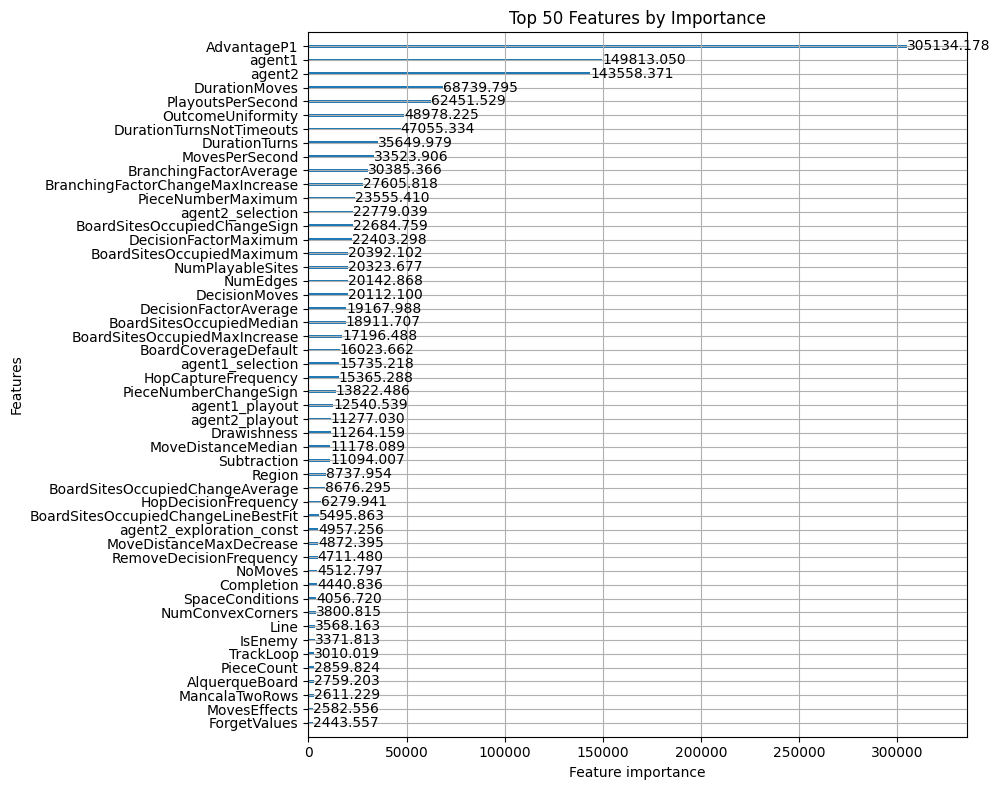

Fold 2 - RMSE: 0.40367156400454124
Fold 3


[100]	valid_0's rmse: 0.520983


[200]	valid_0's rmse: 0.493269


[300]	valid_0's rmse: 0.480212


[400]	valid_0's rmse: 0.472113


[500]	valid_0's rmse: 0.465974


[600]	valid_0's rmse: 0.461217


[700]	valid_0's rmse: 0.457647


[800]	valid_0's rmse: 0.45395


[900]	valid_0's rmse: 0.451306


[1000]	valid_0's rmse: 0.448645


[1100]	valid_0's rmse: 0.44704


[1200]	valid_0's rmse: 0.445615


[1300]	valid_0's rmse: 0.444081


[1400]	valid_0's rmse: 0.442951


[1500]	valid_0's rmse: 0.44199


[1600]	valid_0's rmse: 0.441066


[1700]	valid_0's rmse: 0.440318


[1800]	valid_0's rmse: 0.439719


[1900]	valid_0's rmse: 0.439144


[2000]	valid_0's rmse: 0.438497


[2100]	valid_0's rmse: 0.437907


[2200]	valid_0's rmse: 0.43732


[2300]	valid_0's rmse: 0.436866


[2400]	valid_0's rmse: 0.436457


[2500]	valid_0's rmse: 0.436043


[2600]	valid_0's rmse: 0.435542


[2700]	valid_0's rmse: 0.435057


[2800]	valid_0's rmse: 0.434603


[2900]	valid_0's rmse: 0.434214


[3000]	valid_0's rmse: 0.433958


[3100]	valid_0's rmse: 0.433574


[3200]	valid_0's rmse: 0.433216


[3300]	valid_0's rmse: 0.433041


[3400]	valid_0's rmse: 0.432832


[3500]	valid_0's rmse: 0.43256


[3600]	valid_0's rmse: 0.432319


[3700]	valid_0's rmse: 0.432044


[3800]	valid_0's rmse: 0.431941


[3900]	valid_0's rmse: 0.431786


[4000]	valid_0's rmse: 0.431478


[4100]	valid_0's rmse: 0.431243


[4200]	valid_0's rmse: 0.431098


[4300]	valid_0's rmse: 0.430809


[4400]	valid_0's rmse: 0.430627


[4500]	valid_0's rmse: 0.430428


[4600]	valid_0's rmse: 0.430354


[4700]	valid_0's rmse: 0.430249


[4800]	valid_0's rmse: 0.430135


[4900]	valid_0's rmse: 0.43004


[5000]	valid_0's rmse: 0.429941


[5100]	valid_0's rmse: 0.429864


[5200]	valid_0's rmse: 0.429742


[5300]	valid_0's rmse: 0.429615


[5400]	valid_0's rmse: 0.429484


[5500]	valid_0's rmse: 0.429338


[5600]	valid_0's rmse: 0.429248


[5700]	valid_0's rmse: 0.4292


[5800]	valid_0's rmse: 0.429019


[5900]	valid_0's rmse: 0.428862


[6000]	valid_0's rmse: 0.428831


[6100]	valid_0's rmse: 0.428707


[6200]	valid_0's rmse: 0.428604


[6300]	valid_0's rmse: 0.42845


[6400]	valid_0's rmse: 0.428391


[6500]	valid_0's rmse: 0.428275


[6600]	valid_0's rmse: 0.428317


[6700]	valid_0's rmse: 0.428305


[6800]	valid_0's rmse: 0.42827


[6900]	valid_0's rmse: 0.428272


[7000]	valid_0's rmse: 0.42814


[7100]	valid_0's rmse: 0.428086


[7200]	valid_0's rmse: 0.428014


[7300]	valid_0's rmse: 0.427948


[7400]	valid_0's rmse: 0.427861


[7500]	valid_0's rmse: 0.427848


[7600]	valid_0's rmse: 0.427781


[7700]	valid_0's rmse: 0.427691


[7800]	valid_0's rmse: 0.42763


[7900]	valid_0's rmse: 0.427555


[8000]	valid_0's rmse: 0.42746


[8100]	valid_0's rmse: 0.427471


[8200]	valid_0's rmse: 0.427438


[8300]	valid_0's rmse: 0.427392


[8400]	valid_0's rmse: 0.427359


[8500]	valid_0's rmse: 0.427266


[8600]	valid_0's rmse: 0.42725


[8700]	valid_0's rmse: 0.427266


[8800]	valid_0's rmse: 0.4272


[8900]	valid_0's rmse: 0.427174


[9000]	valid_0's rmse: 0.427168


[9100]	valid_0's rmse: 0.427114


[9200]	valid_0's rmse: 0.427067


[9300]	valid_0's rmse: 0.427043


[9400]	valid_0's rmse: 0.426997


[9500]	valid_0's rmse: 0.426987


[9600]	valid_0's rmse: 0.426961


[9700]	valid_0's rmse: 0.426902


[9800]	valid_0's rmse: 0.42689


[9900]	valid_0's rmse: 0.426867


[10000]	valid_0's rmse: 0.42687


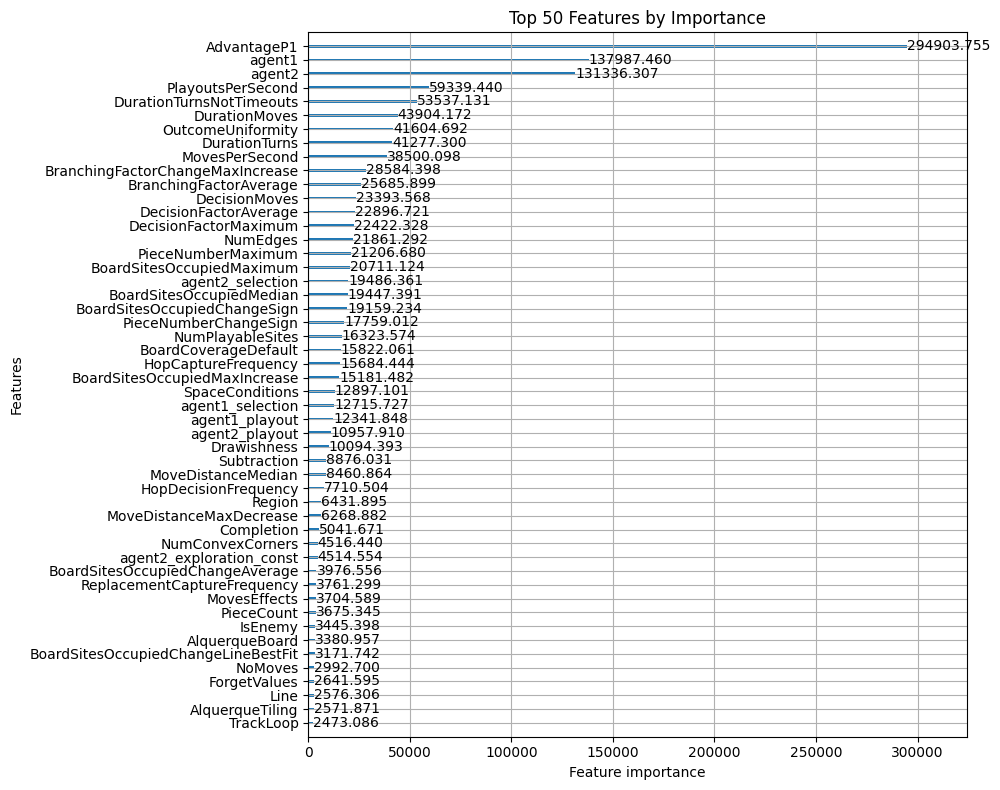

Fold 3 - RMSE: 0.42622288417435855
Fold 4


[100]	valid_0's rmse: 0.519504


[200]	valid_0's rmse: 0.490397


[300]	valid_0's rmse: 0.478268


[400]	valid_0's rmse: 0.469703


[500]	valid_0's rmse: 0.463513


[600]	valid_0's rmse: 0.459482


[700]	valid_0's rmse: 0.456152


[800]	valid_0's rmse: 0.453569


[900]	valid_0's rmse: 0.451463


[1000]	valid_0's rmse: 0.449956


[1100]	valid_0's rmse: 0.448773


[1200]	valid_0's rmse: 0.448038


[1300]	valid_0's rmse: 0.447203


[1400]	valid_0's rmse: 0.446399


[1500]	valid_0's rmse: 0.44557


[1600]	valid_0's rmse: 0.444909


[1700]	valid_0's rmse: 0.444386


[1800]	valid_0's rmse: 0.443841


[1900]	valid_0's rmse: 0.443296


[2000]	valid_0's rmse: 0.442808


[2100]	valid_0's rmse: 0.442447


[2200]	valid_0's rmse: 0.442018


[2300]	valid_0's rmse: 0.441735


[2400]	valid_0's rmse: 0.441366


[2500]	valid_0's rmse: 0.440863


[2600]	valid_0's rmse: 0.440713


[2700]	valid_0's rmse: 0.440392


[2800]	valid_0's rmse: 0.44002


[2900]	valid_0's rmse: 0.439645


[3000]	valid_0's rmse: 0.43932


[3100]	valid_0's rmse: 0.439187


[3200]	valid_0's rmse: 0.438909


[3300]	valid_0's rmse: 0.438644


[3400]	valid_0's rmse: 0.438406


[3500]	valid_0's rmse: 0.438376


[3600]	valid_0's rmse: 0.438282


[3700]	valid_0's rmse: 0.438106


[3800]	valid_0's rmse: 0.437888


[3900]	valid_0's rmse: 0.437621


[4000]	valid_0's rmse: 0.437459


[4100]	valid_0's rmse: 0.437354


[4200]	valid_0's rmse: 0.437157


[4300]	valid_0's rmse: 0.437017


[4400]	valid_0's rmse: 0.436976


[4500]	valid_0's rmse: 0.436832


[4600]	valid_0's rmse: 0.436729


[4700]	valid_0's rmse: 0.436649


[4800]	valid_0's rmse: 0.436639


[4900]	valid_0's rmse: 0.436562


[5000]	valid_0's rmse: 0.436504


[5100]	valid_0's rmse: 0.436427


[5200]	valid_0's rmse: 0.436273


[5300]	valid_0's rmse: 0.43623


[5400]	valid_0's rmse: 0.43611


[5500]	valid_0's rmse: 0.435888


[5600]	valid_0's rmse: 0.435807


[5700]	valid_0's rmse: 0.435771


[5800]	valid_0's rmse: 0.435706


[5900]	valid_0's rmse: 0.435565


[6000]	valid_0's rmse: 0.435451


[6100]	valid_0's rmse: 0.435382


[6200]	valid_0's rmse: 0.435333


[6300]	valid_0's rmse: 0.435235


[6400]	valid_0's rmse: 0.435229


[6500]	valid_0's rmse: 0.43515


[6600]	valid_0's rmse: 0.435156


[6700]	valid_0's rmse: 0.435034


[6800]	valid_0's rmse: 0.434953


[6900]	valid_0's rmse: 0.434881


[7000]	valid_0's rmse: 0.434818


[7100]	valid_0's rmse: 0.434758


[7200]	valid_0's rmse: 0.434635


[7300]	valid_0's rmse: 0.434624


[7400]	valid_0's rmse: 0.434579


[7500]	valid_0's rmse: 0.434526


[7600]	valid_0's rmse: 0.434561


[7700]	valid_0's rmse: 0.434532


[7800]	valid_0's rmse: 0.434475


[7900]	valid_0's rmse: 0.434533


[8000]	valid_0's rmse: 0.434461


[8100]	valid_0's rmse: 0.434401


[8200]	valid_0's rmse: 0.434428


[8300]	valid_0's rmse: 0.434362


[8400]	valid_0's rmse: 0.434303


[8500]	valid_0's rmse: 0.434317


[8600]	valid_0's rmse: 0.434316


[8700]	valid_0's rmse: 0.434285


[8800]	valid_0's rmse: 0.434245


[8900]	valid_0's rmse: 0.434219


[9000]	valid_0's rmse: 0.434211


[9100]	valid_0's rmse: 0.434161


[9200]	valid_0's rmse: 0.434152


[9300]	valid_0's rmse: 0.434111


[9400]	valid_0's rmse: 0.434089


[9500]	valid_0's rmse: 0.43406


[9600]	valid_0's rmse: 0.43405


[9700]	valid_0's rmse: 0.434046


[9800]	valid_0's rmse: 0.434073


[9900]	valid_0's rmse: 0.433993


[10000]	valid_0's rmse: 0.434021


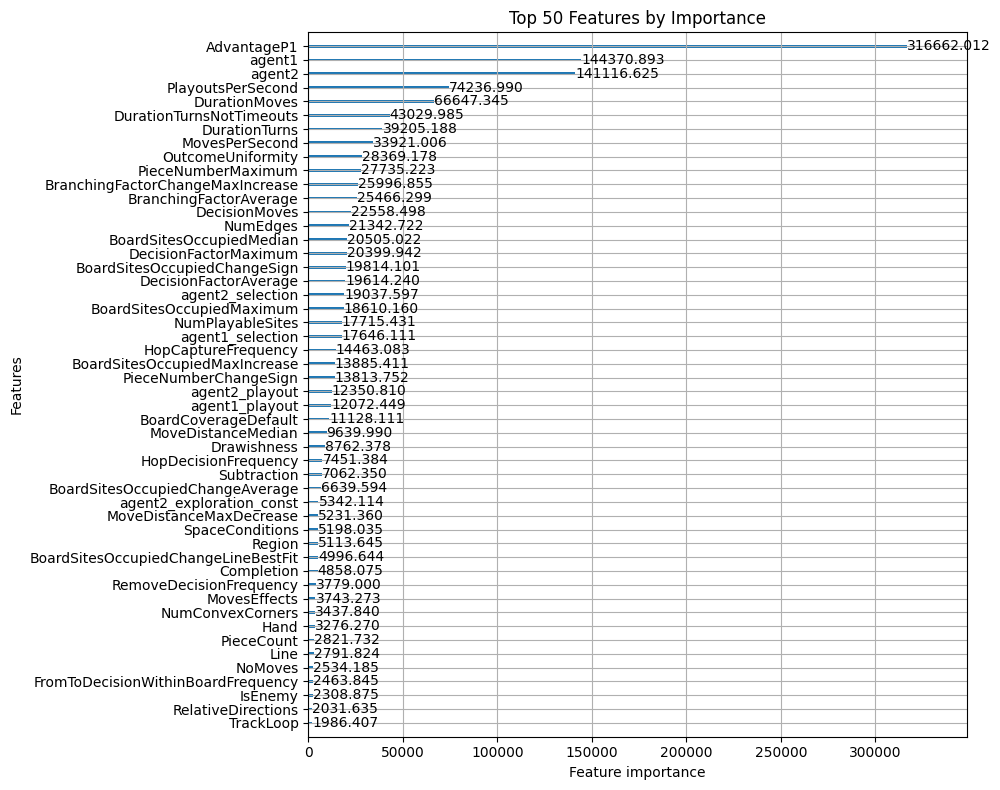

Fold 4 - RMSE: 0.43356706358668884
Fold 5


[100]	valid_0's rmse: 0.511735


[200]	valid_0's rmse: 0.486641


[300]	valid_0's rmse: 0.472701


[400]	valid_0's rmse: 0.464128


[500]	valid_0's rmse: 0.457977


[600]	valid_0's rmse: 0.452859


[700]	valid_0's rmse: 0.449137


[800]	valid_0's rmse: 0.446239


[900]	valid_0's rmse: 0.443275


[1000]	valid_0's rmse: 0.441122


[1100]	valid_0's rmse: 0.43948


[1200]	valid_0's rmse: 0.43834


[1300]	valid_0's rmse: 0.436727


[1400]	valid_0's rmse: 0.435403


[1500]	valid_0's rmse: 0.4344


[1600]	valid_0's rmse: 0.433444


[1700]	valid_0's rmse: 0.43248


[1800]	valid_0's rmse: 0.431736


[1900]	valid_0's rmse: 0.431061


[2000]	valid_0's rmse: 0.430631


[2100]	valid_0's rmse: 0.430022


[2200]	valid_0's rmse: 0.429509


[2300]	valid_0's rmse: 0.429036


[2400]	valid_0's rmse: 0.428511


[2500]	valid_0's rmse: 0.428211


[2600]	valid_0's rmse: 0.427829


[2700]	valid_0's rmse: 0.427604


[2800]	valid_0's rmse: 0.42725


[2900]	valid_0's rmse: 0.426833


[3000]	valid_0's rmse: 0.426512


[3100]	valid_0's rmse: 0.426137


[3200]	valid_0's rmse: 0.425853


[3300]	valid_0's rmse: 0.425543


[3400]	valid_0's rmse: 0.425301


[3500]	valid_0's rmse: 0.425108


[3600]	valid_0's rmse: 0.424907


[3700]	valid_0's rmse: 0.424596


[3800]	valid_0's rmse: 0.424381


[3900]	valid_0's rmse: 0.424293


[4000]	valid_0's rmse: 0.424181


[4100]	valid_0's rmse: 0.423939


[4200]	valid_0's rmse: 0.423765


[4300]	valid_0's rmse: 0.423584


[4400]	valid_0's rmse: 0.423373


[4500]	valid_0's rmse: 0.423185


[4600]	valid_0's rmse: 0.423022


[4700]	valid_0's rmse: 0.42288


[4800]	valid_0's rmse: 0.422895


[4900]	valid_0's rmse: 0.42281


[5000]	valid_0's rmse: 0.422707


[5100]	valid_0's rmse: 0.422648


[5200]	valid_0's rmse: 0.422526


[5300]	valid_0's rmse: 0.422389


[5400]	valid_0's rmse: 0.422229


[5500]	valid_0's rmse: 0.422178


[5600]	valid_0's rmse: 0.42208


[5700]	valid_0's rmse: 0.421986


[5800]	valid_0's rmse: 0.42191


[5900]	valid_0's rmse: 0.421802


[6000]	valid_0's rmse: 0.421651


[6100]	valid_0's rmse: 0.4216


[6200]	valid_0's rmse: 0.421514


[6300]	valid_0's rmse: 0.421419


[6400]	valid_0's rmse: 0.421383


[6500]	valid_0's rmse: 0.421322


[6600]	valid_0's rmse: 0.421312


[6700]	valid_0's rmse: 0.421236


[6800]	valid_0's rmse: 0.421142


[6900]	valid_0's rmse: 0.421083


[7000]	valid_0's rmse: 0.420977


[7100]	valid_0's rmse: 0.42087


[7200]	valid_0's rmse: 0.420881


[7300]	valid_0's rmse: 0.420802


[7400]	valid_0's rmse: 0.420709


[7500]	valid_0's rmse: 0.420617


[7600]	valid_0's rmse: 0.420556


[7700]	valid_0's rmse: 0.42047


[7800]	valid_0's rmse: 0.420471


[7900]	valid_0's rmse: 0.420485


[8000]	valid_0's rmse: 0.420428


[8100]	valid_0's rmse: 0.420376


[8200]	valid_0's rmse: 0.420383


[8300]	valid_0's rmse: 0.420307


[8400]	valid_0's rmse: 0.420282


[8500]	valid_0's rmse: 0.420219


[8600]	valid_0's rmse: 0.420207


[8700]	valid_0's rmse: 0.420228


[8800]	valid_0's rmse: 0.420191


[8900]	valid_0's rmse: 0.420187


[9000]	valid_0's rmse: 0.420162


[9100]	valid_0's rmse: 0.420176


[9200]	valid_0's rmse: 0.420153


[9300]	valid_0's rmse: 0.420101


[9400]	valid_0's rmse: 0.420139


[9500]	valid_0's rmse: 0.420103


[9600]	valid_0's rmse: 0.420086


[9700]	valid_0's rmse: 0.420065


[9800]	valid_0's rmse: 0.420036


[9900]	valid_0's rmse: 0.42003


[10000]	valid_0's rmse: 0.420007


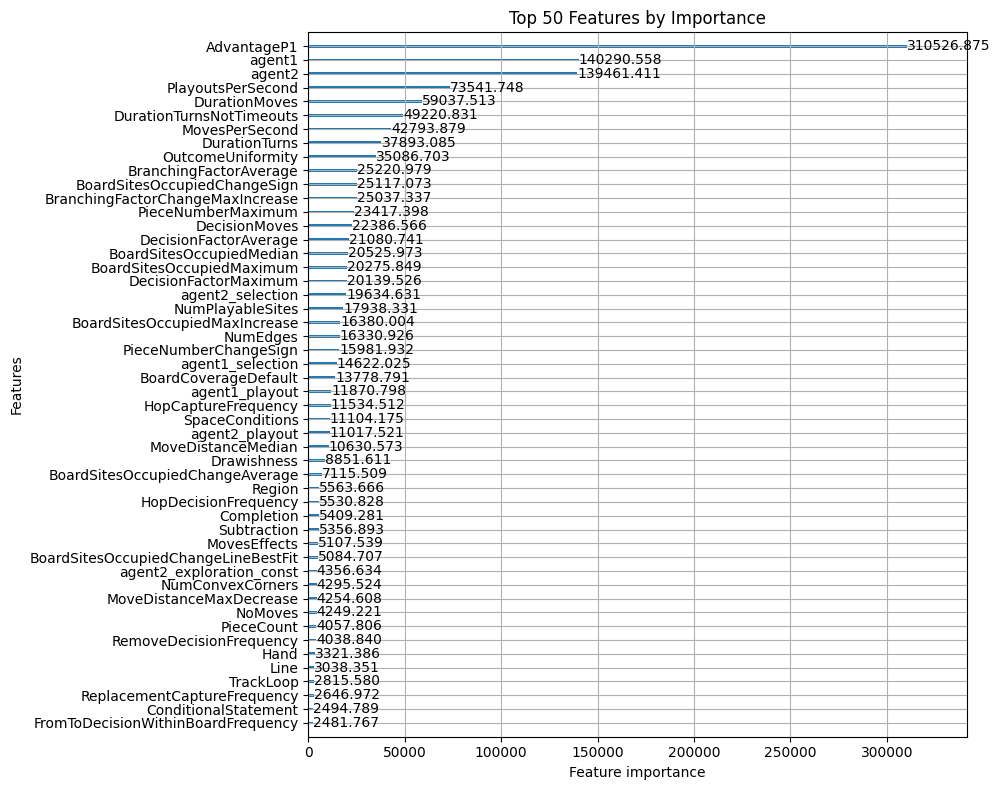

Fold 5 - RMSE: 0.41931097437974285
List of oof scores: [0.40973817440785737, 0.40367156400454124, 0.42622288417435855, 0.43356706358668884, 0.41931097437974285]
Average oof score: 0.4185021321106378


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv2.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.497963


[200]	valid_0's rmse: 0.473518


[300]	valid_0's rmse: 0.462908


[400]	valid_0's rmse: 0.457474


[500]	valid_0's rmse: 0.45321


[600]	valid_0's rmse: 0.4493


[700]	valid_0's rmse: 0.44591


[800]	valid_0's rmse: 0.443773


[900]	valid_0's rmse: 0.441866


[1000]	valid_0's rmse: 0.4401


[1100]	valid_0's rmse: 0.438762


[1200]	valid_0's rmse: 0.437703


[1300]	valid_0's rmse: 0.436727


[1400]	valid_0's rmse: 0.435974


[1500]	valid_0's rmse: 0.435064


[1600]	valid_0's rmse: 0.434457


[1700]	valid_0's rmse: 0.433776


[1800]	valid_0's rmse: 0.433347


[1900]	valid_0's rmse: 0.432961


[2000]	valid_0's rmse: 0.432303


[2100]	valid_0's rmse: 0.431834


[2200]	valid_0's rmse: 0.431499


[2300]	valid_0's rmse: 0.431125


[2400]	valid_0's rmse: 0.430819


[2500]	valid_0's rmse: 0.430449


[2600]	valid_0's rmse: 0.43016


[2700]	valid_0's rmse: 0.429953


[2800]	valid_0's rmse: 0.429748


[2900]	valid_0's rmse: 0.429417


[3000]	valid_0's rmse: 0.429201


[3100]	valid_0's rmse: 0.42897


[3200]	valid_0's rmse: 0.42885


[3300]	valid_0's rmse: 0.428717


[3400]	valid_0's rmse: 0.428481


[3500]	valid_0's rmse: 0.428279


[3600]	valid_0's rmse: 0.428068


[3700]	valid_0's rmse: 0.427914


[3800]	valid_0's rmse: 0.42772


[3900]	valid_0's rmse: 0.427567


[4000]	valid_0's rmse: 0.427447


[4100]	valid_0's rmse: 0.427305


[4200]	valid_0's rmse: 0.427241


[4300]	valid_0's rmse: 0.427184


[4400]	valid_0's rmse: 0.427083


[4500]	valid_0's rmse: 0.427111


[4600]	valid_0's rmse: 0.426969


[4700]	valid_0's rmse: 0.426963


[4800]	valid_0's rmse: 0.426849


[4900]	valid_0's rmse: 0.426814


[5000]	valid_0's rmse: 0.426753


[5100]	valid_0's rmse: 0.426667


[5200]	valid_0's rmse: 0.426623


[5300]	valid_0's rmse: 0.426533


[5400]	valid_0's rmse: 0.426535


[5500]	valid_0's rmse: 0.426479


[5600]	valid_0's rmse: 0.42638


[5700]	valid_0's rmse: 0.426232


[5800]	valid_0's rmse: 0.426188


[5900]	valid_0's rmse: 0.426113


[6000]	valid_0's rmse: 0.426057


[6100]	valid_0's rmse: 0.425987


[6200]	valid_0's rmse: 0.425996


[6300]	valid_0's rmse: 0.425981


[6400]	valid_0's rmse: 0.425924


[6500]	valid_0's rmse: 0.42586


[6600]	valid_0's rmse: 0.42581


[6700]	valid_0's rmse: 0.425808


[6800]	valid_0's rmse: 0.42587


[6900]	valid_0's rmse: 0.425865


[7000]	valid_0's rmse: 0.425841


[7100]	valid_0's rmse: 0.425875


[7200]	valid_0's rmse: 0.425808


[7300]	valid_0's rmse: 0.425748


[7400]	valid_0's rmse: 0.42571


[7500]	valid_0's rmse: 0.425708


[7600]	valid_0's rmse: 0.425712


[7700]	valid_0's rmse: 0.425734


[7800]	valid_0's rmse: 0.425694


[7900]	valid_0's rmse: 0.425687


[8000]	valid_0's rmse: 0.425645


[8100]	valid_0's rmse: 0.425686


[8200]	valid_0's rmse: 0.425685


[8300]	valid_0's rmse: 0.425651


[8400]	valid_0's rmse: 0.425681


[8500]	valid_0's rmse: 0.425672


[8600]	valid_0's rmse: 0.425672


[8700]	valid_0's rmse: 0.425637


[8800]	valid_0's rmse: 0.425598


[8900]	valid_0's rmse: 0.425573


[9000]	valid_0's rmse: 0.425517


[9100]	valid_0's rmse: 0.425522


[9200]	valid_0's rmse: 0.425486


[9300]	valid_0's rmse: 0.42547


[9400]	valid_0's rmse: 0.425425


[9500]	valid_0's rmse: 0.425424


[9600]	valid_0's rmse: 0.425424


[9700]	valid_0's rmse: 0.425455


[9800]	valid_0's rmse: 0.425419


[9900]	valid_0's rmse: 0.425418


[10000]	valid_0's rmse: 0.425396


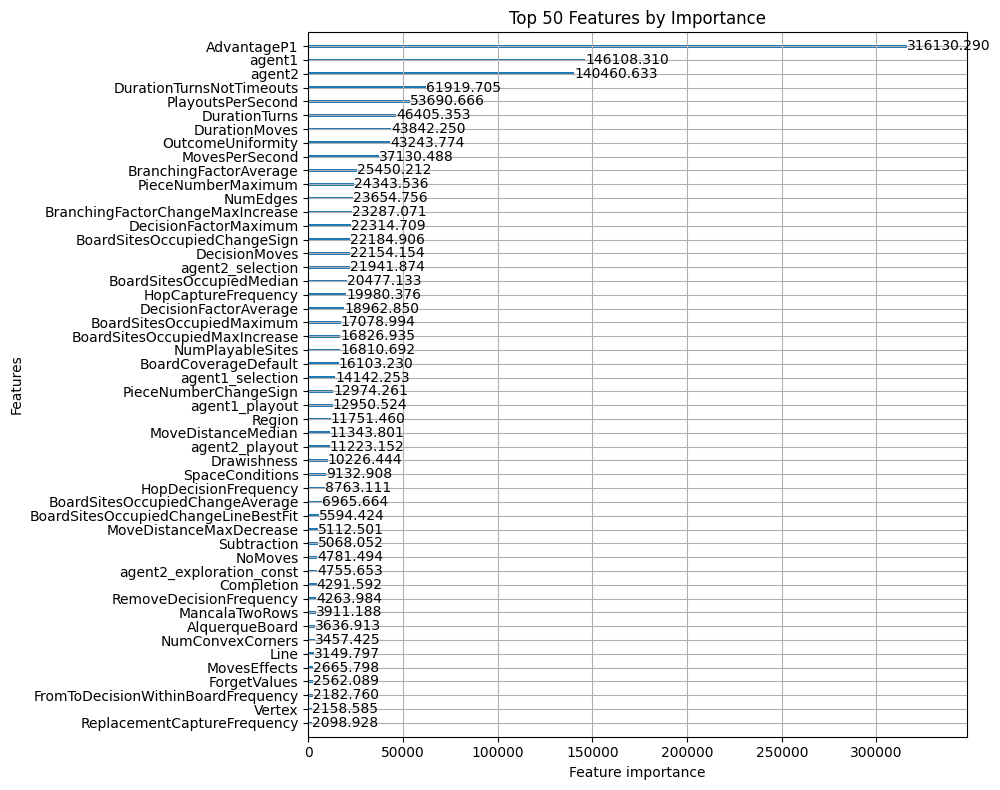

Fold 1 - RMSE: 0.4249407799683842
Fold 2


[100]	valid_0's rmse: 0.504758


[200]	valid_0's rmse: 0.479734


[300]	valid_0's rmse: 0.467204


[400]	valid_0's rmse: 0.460359


[500]	valid_0's rmse: 0.456082


[600]	valid_0's rmse: 0.45164


[700]	valid_0's rmse: 0.447649


[800]	valid_0's rmse: 0.444827


[900]	valid_0's rmse: 0.442385


[1000]	valid_0's rmse: 0.44024


[1100]	valid_0's rmse: 0.438465


[1200]	valid_0's rmse: 0.436871


[1300]	valid_0's rmse: 0.435221


[1400]	valid_0's rmse: 0.434144


[1500]	valid_0's rmse: 0.432832


[1600]	valid_0's rmse: 0.431836


[1700]	valid_0's rmse: 0.431079


[1800]	valid_0's rmse: 0.430247


[1900]	valid_0's rmse: 0.42963


[2000]	valid_0's rmse: 0.428856


[2100]	valid_0's rmse: 0.428146


[2200]	valid_0's rmse: 0.427608


[2300]	valid_0's rmse: 0.426961


[2400]	valid_0's rmse: 0.426394


[2500]	valid_0's rmse: 0.426049


[2600]	valid_0's rmse: 0.425627


[2700]	valid_0's rmse: 0.425193


[2800]	valid_0's rmse: 0.424744


[2900]	valid_0's rmse: 0.424375


[3000]	valid_0's rmse: 0.423928


[3100]	valid_0's rmse: 0.423625


[3200]	valid_0's rmse: 0.423258


[3300]	valid_0's rmse: 0.422952


[3400]	valid_0's rmse: 0.422668


[3500]	valid_0's rmse: 0.422397


[3600]	valid_0's rmse: 0.422167


[3700]	valid_0's rmse: 0.421949


[3800]	valid_0's rmse: 0.421702


[3900]	valid_0's rmse: 0.421461


[4000]	valid_0's rmse: 0.421298


[4100]	valid_0's rmse: 0.420997


[4200]	valid_0's rmse: 0.420811


[4300]	valid_0's rmse: 0.420617


[4400]	valid_0's rmse: 0.420429


[4500]	valid_0's rmse: 0.420335


[4600]	valid_0's rmse: 0.42018


[4700]	valid_0's rmse: 0.420004


[4800]	valid_0's rmse: 0.419863


[4900]	valid_0's rmse: 0.419695


[5000]	valid_0's rmse: 0.419712


[5100]	valid_0's rmse: 0.419589


[5200]	valid_0's rmse: 0.419356


[5300]	valid_0's rmse: 0.419203


[5400]	valid_0's rmse: 0.419111


[5500]	valid_0's rmse: 0.419069


[5600]	valid_0's rmse: 0.418863


[5700]	valid_0's rmse: 0.418773


[5800]	valid_0's rmse: 0.418712


[5900]	valid_0's rmse: 0.418663


[6000]	valid_0's rmse: 0.418631


[6100]	valid_0's rmse: 0.418529


[6200]	valid_0's rmse: 0.418486


[6300]	valid_0's rmse: 0.418461


[6400]	valid_0's rmse: 0.418443


[6500]	valid_0's rmse: 0.418342


[6600]	valid_0's rmse: 0.418284


[6700]	valid_0's rmse: 0.418198


[6800]	valid_0's rmse: 0.418056


[6900]	valid_0's rmse: 0.417918


[7000]	valid_0's rmse: 0.417802


[7100]	valid_0's rmse: 0.417712


[7200]	valid_0's rmse: 0.417679


[7300]	valid_0's rmse: 0.417655


[7400]	valid_0's rmse: 0.417585


[7500]	valid_0's rmse: 0.417494


[7600]	valid_0's rmse: 0.417452


[7700]	valid_0's rmse: 0.417371


[7800]	valid_0's rmse: 0.41726


[7900]	valid_0's rmse: 0.417197


[8000]	valid_0's rmse: 0.417166


[8100]	valid_0's rmse: 0.417118


[8200]	valid_0's rmse: 0.41706


[8300]	valid_0's rmse: 0.417


[8400]	valid_0's rmse: 0.416976


[8500]	valid_0's rmse: 0.416952


[8600]	valid_0's rmse: 0.416901


[8700]	valid_0's rmse: 0.416843


[8800]	valid_0's rmse: 0.416811


[8900]	valid_0's rmse: 0.416738


[9000]	valid_0's rmse: 0.41672


[9100]	valid_0's rmse: 0.416652


[9200]	valid_0's rmse: 0.41663


[9300]	valid_0's rmse: 0.416616


[9400]	valid_0's rmse: 0.416653


[9500]	valid_0's rmse: 0.416579


[9600]	valid_0's rmse: 0.41655


[9700]	valid_0's rmse: 0.416518


[9800]	valid_0's rmse: 0.416497


[9900]	valid_0's rmse: 0.416471


[10000]	valid_0's rmse: 0.41648


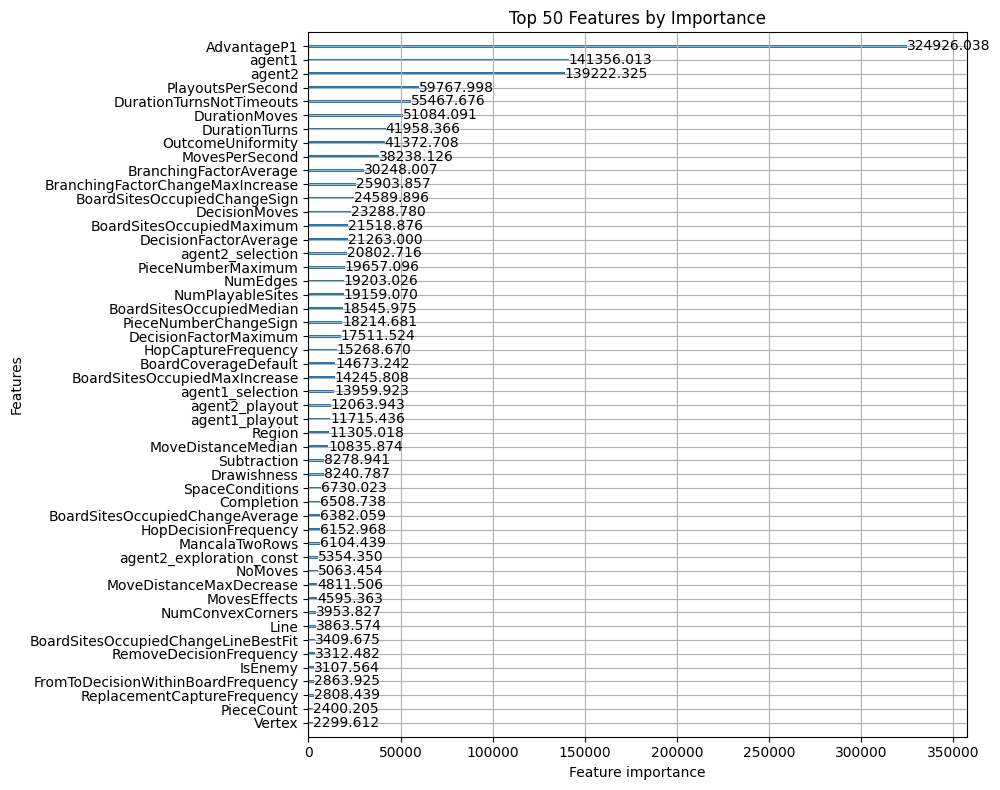

Fold 2 - RMSE: 0.4159430501807028
Fold 3


[100]	valid_0's rmse: 0.490162


[200]	valid_0's rmse: 0.467909


[300]	valid_0's rmse: 0.457993


[400]	valid_0's rmse: 0.452038


[500]	valid_0's rmse: 0.448054


[600]	valid_0's rmse: 0.444749


[700]	valid_0's rmse: 0.442635


[800]	valid_0's rmse: 0.440777


[900]	valid_0's rmse: 0.439076


[1000]	valid_0's rmse: 0.437749


[1100]	valid_0's rmse: 0.436526


[1200]	valid_0's rmse: 0.435449


[1300]	valid_0's rmse: 0.434347


[1400]	valid_0's rmse: 0.433393


[1500]	valid_0's rmse: 0.432783


[1600]	valid_0's rmse: 0.432021


[1700]	valid_0's rmse: 0.431287


[1800]	valid_0's rmse: 0.430786


[1900]	valid_0's rmse: 0.430369


[2000]	valid_0's rmse: 0.429762


[2100]	valid_0's rmse: 0.429389


[2200]	valid_0's rmse: 0.429061


[2300]	valid_0's rmse: 0.428775


[2400]	valid_0's rmse: 0.428399


[2500]	valid_0's rmse: 0.428077


[2600]	valid_0's rmse: 0.427838


[2700]	valid_0's rmse: 0.42743


[2800]	valid_0's rmse: 0.427166


[2900]	valid_0's rmse: 0.426898


[3000]	valid_0's rmse: 0.426643


[3100]	valid_0's rmse: 0.426487


[3200]	valid_0's rmse: 0.426222


[3300]	valid_0's rmse: 0.425913


[3400]	valid_0's rmse: 0.425766


[3500]	valid_0's rmse: 0.425628


[3600]	valid_0's rmse: 0.425418


[3700]	valid_0's rmse: 0.425249


[3800]	valid_0's rmse: 0.425176


[3900]	valid_0's rmse: 0.425083


[4000]	valid_0's rmse: 0.425001


[4100]	valid_0's rmse: 0.424822


[4200]	valid_0's rmse: 0.424704


[4300]	valid_0's rmse: 0.424585


[4400]	valid_0's rmse: 0.424476


[4500]	valid_0's rmse: 0.42426


[4600]	valid_0's rmse: 0.424202


[4700]	valid_0's rmse: 0.42403


[4800]	valid_0's rmse: 0.423981


[4900]	valid_0's rmse: 0.423938


[5000]	valid_0's rmse: 0.423871


[5100]	valid_0's rmse: 0.423725


[5200]	valid_0's rmse: 0.423662


[5300]	valid_0's rmse: 0.423603


[5400]	valid_0's rmse: 0.423512


[5500]	valid_0's rmse: 0.423439


[5600]	valid_0's rmse: 0.423422


[5700]	valid_0's rmse: 0.423422


[5800]	valid_0's rmse: 0.423395


[5900]	valid_0's rmse: 0.423284


[6000]	valid_0's rmse: 0.423268


[6100]	valid_0's rmse: 0.423136


[6200]	valid_0's rmse: 0.423132


[6300]	valid_0's rmse: 0.423127


[6400]	valid_0's rmse: 0.423084


[6500]	valid_0's rmse: 0.422925


[6600]	valid_0's rmse: 0.422855


[6700]	valid_0's rmse: 0.422858


[6800]	valid_0's rmse: 0.422811


[6900]	valid_0's rmse: 0.422801


[7000]	valid_0's rmse: 0.422766


[7100]	valid_0's rmse: 0.422625


[7200]	valid_0's rmse: 0.422664


[7300]	valid_0's rmse: 0.42267


[7400]	valid_0's rmse: 0.422692


[7500]	valid_0's rmse: 0.422735


[7600]	valid_0's rmse: 0.422659


[7700]	valid_0's rmse: 0.422606


[7800]	valid_0's rmse: 0.42255


[7900]	valid_0's rmse: 0.422498


[8000]	valid_0's rmse: 0.422509


[8100]	valid_0's rmse: 0.422487


[8200]	valid_0's rmse: 0.422442


[8300]	valid_0's rmse: 0.422441


[8400]	valid_0's rmse: 0.422428


[8500]	valid_0's rmse: 0.422342


[8600]	valid_0's rmse: 0.422319


[8700]	valid_0's rmse: 0.422329


[8800]	valid_0's rmse: 0.422272


[8900]	valid_0's rmse: 0.422268


[9000]	valid_0's rmse: 0.422232


[9100]	valid_0's rmse: 0.422274


[9200]	valid_0's rmse: 0.422311


[9300]	valid_0's rmse: 0.42235


[9400]	valid_0's rmse: 0.422322


[9500]	valid_0's rmse: 0.422279


[9600]	valid_0's rmse: 0.422234


[9700]	valid_0's rmse: 0.422223


[9800]	valid_0's rmse: 0.42221


[9900]	valid_0's rmse: 0.422227


[10000]	valid_0's rmse: 0.422213


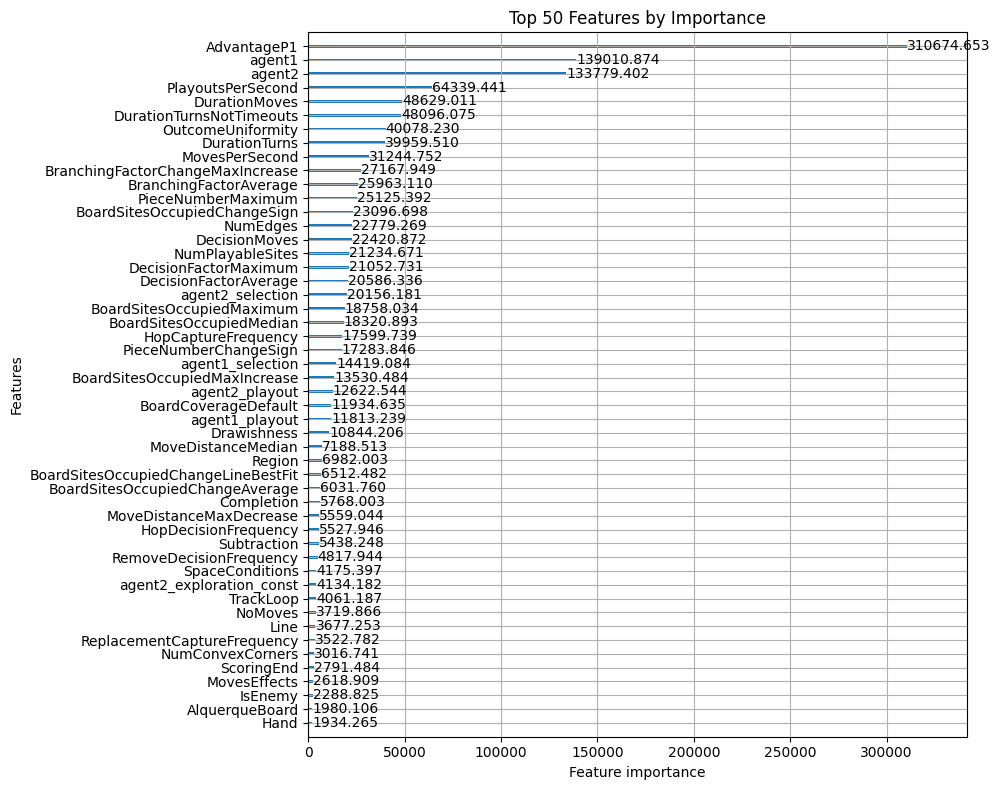

Fold 3 - RMSE: 0.42153060199955394
Fold 4


[100]	valid_0's rmse: 0.486268


[200]	valid_0's rmse: 0.462297


[300]	valid_0's rmse: 0.451669


[400]	valid_0's rmse: 0.445563


[500]	valid_0's rmse: 0.441434


[600]	valid_0's rmse: 0.437999


[700]	valid_0's rmse: 0.434779


[800]	valid_0's rmse: 0.432777


[900]	valid_0's rmse: 0.431267


[1000]	valid_0's rmse: 0.429963


[1100]	valid_0's rmse: 0.428563


[1200]	valid_0's rmse: 0.427678


[1300]	valid_0's rmse: 0.426674


[1400]	valid_0's rmse: 0.425679


[1500]	valid_0's rmse: 0.425005


[1600]	valid_0's rmse: 0.424397


[1700]	valid_0's rmse: 0.424132


[1800]	valid_0's rmse: 0.423716


[1900]	valid_0's rmse: 0.423188


[2000]	valid_0's rmse: 0.422867


[2100]	valid_0's rmse: 0.422408


[2200]	valid_0's rmse: 0.422029


[2300]	valid_0's rmse: 0.421585


[2400]	valid_0's rmse: 0.421227


[2500]	valid_0's rmse: 0.420904


[2600]	valid_0's rmse: 0.420732


[2700]	valid_0's rmse: 0.42047


[2800]	valid_0's rmse: 0.420319


[2900]	valid_0's rmse: 0.420003


[3000]	valid_0's rmse: 0.419746


[3100]	valid_0's rmse: 0.419493


[3200]	valid_0's rmse: 0.419211


[3300]	valid_0's rmse: 0.419013


[3400]	valid_0's rmse: 0.418887


[3500]	valid_0's rmse: 0.418638


[3600]	valid_0's rmse: 0.418484


[3700]	valid_0's rmse: 0.418276


[3800]	valid_0's rmse: 0.418094


[3900]	valid_0's rmse: 0.417998


[4000]	valid_0's rmse: 0.417786


[4100]	valid_0's rmse: 0.417697


[4200]	valid_0's rmse: 0.417573


[4300]	valid_0's rmse: 0.417466


[4400]	valid_0's rmse: 0.417347


[4500]	valid_0's rmse: 0.417254


[4600]	valid_0's rmse: 0.417122


[4700]	valid_0's rmse: 0.416987


[4800]	valid_0's rmse: 0.416858


[4900]	valid_0's rmse: 0.416696


[5000]	valid_0's rmse: 0.416586


[5100]	valid_0's rmse: 0.416504


[5200]	valid_0's rmse: 0.416395


[5300]	valid_0's rmse: 0.416272


[5400]	valid_0's rmse: 0.416177


[5500]	valid_0's rmse: 0.416017


[5600]	valid_0's rmse: 0.415947


[5700]	valid_0's rmse: 0.415841


[5800]	valid_0's rmse: 0.415854


[5900]	valid_0's rmse: 0.415747


[6000]	valid_0's rmse: 0.415693


[6100]	valid_0's rmse: 0.415627


[6200]	valid_0's rmse: 0.415566


[6300]	valid_0's rmse: 0.415457


[6400]	valid_0's rmse: 0.415381


[6500]	valid_0's rmse: 0.415335


[6600]	valid_0's rmse: 0.415284


[6700]	valid_0's rmse: 0.415307


[6800]	valid_0's rmse: 0.415159


[6900]	valid_0's rmse: 0.415072


[7000]	valid_0's rmse: 0.415069


[7100]	valid_0's rmse: 0.41502


[7200]	valid_0's rmse: 0.41502


[7300]	valid_0's rmse: 0.415006


[7400]	valid_0's rmse: 0.414929


[7500]	valid_0's rmse: 0.4149


[7600]	valid_0's rmse: 0.414851


[7700]	valid_0's rmse: 0.414797


[7800]	valid_0's rmse: 0.414761


[7900]	valid_0's rmse: 0.414737


[8000]	valid_0's rmse: 0.414712


[8100]	valid_0's rmse: 0.414715


[8200]	valid_0's rmse: 0.41469


[8300]	valid_0's rmse: 0.414639


[8400]	valid_0's rmse: 0.414635


[8500]	valid_0's rmse: 0.41459


[8600]	valid_0's rmse: 0.414605


[8700]	valid_0's rmse: 0.414568


[8800]	valid_0's rmse: 0.414501


[8900]	valid_0's rmse: 0.414444


[9000]	valid_0's rmse: 0.414464


[9100]	valid_0's rmse: 0.414442


[9200]	valid_0's rmse: 0.414439


[9300]	valid_0's rmse: 0.41449


[9400]	valid_0's rmse: 0.414516


[9500]	valid_0's rmse: 0.414489


[9600]	valid_0's rmse: 0.414504


[9700]	valid_0's rmse: 0.414468


[9800]	valid_0's rmse: 0.414479


[9900]	valid_0's rmse: 0.414455


[10000]	valid_0's rmse: 0.414432


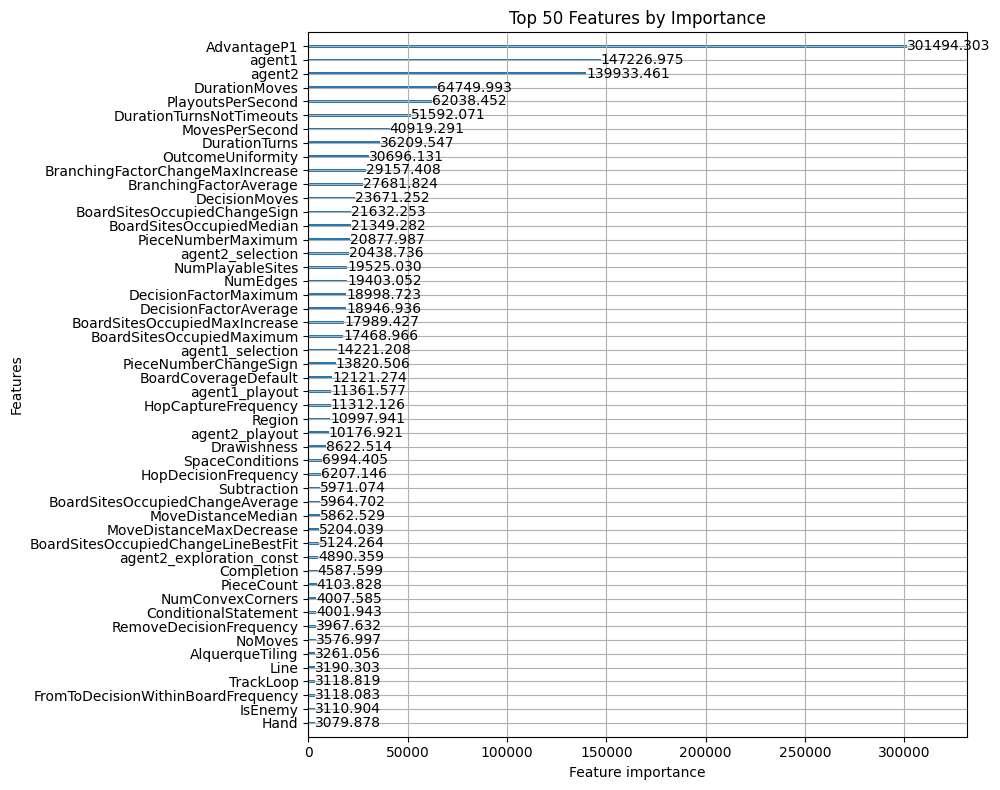

Fold 4 - RMSE: 0.4138203641528024
Fold 5


[100]	valid_0's rmse: 0.507439


[200]	valid_0's rmse: 0.482907


[300]	valid_0's rmse: 0.467357


[400]	valid_0's rmse: 0.458689


[500]	valid_0's rmse: 0.452133


[600]	valid_0's rmse: 0.447403


[700]	valid_0's rmse: 0.4431


[800]	valid_0's rmse: 0.440171


[900]	valid_0's rmse: 0.437119


[1000]	valid_0's rmse: 0.435027


[1100]	valid_0's rmse: 0.433388


[1200]	valid_0's rmse: 0.432025


[1300]	valid_0's rmse: 0.430637


[1400]	valid_0's rmse: 0.429459


[1500]	valid_0's rmse: 0.428449


[1600]	valid_0's rmse: 0.427647


[1700]	valid_0's rmse: 0.427111


[1800]	valid_0's rmse: 0.426118


[1900]	valid_0's rmse: 0.425486


[2000]	valid_0's rmse: 0.424723


[2100]	valid_0's rmse: 0.424245


[2200]	valid_0's rmse: 0.423742


[2300]	valid_0's rmse: 0.423264


[2400]	valid_0's rmse: 0.422892


[2500]	valid_0's rmse: 0.422426


[2600]	valid_0's rmse: 0.422038


[2700]	valid_0's rmse: 0.421663


[2800]	valid_0's rmse: 0.421324


[2900]	valid_0's rmse: 0.420974


[3000]	valid_0's rmse: 0.420796


[3100]	valid_0's rmse: 0.420426


[3200]	valid_0's rmse: 0.420148


[3300]	valid_0's rmse: 0.41982


[3400]	valid_0's rmse: 0.41958


[3500]	valid_0's rmse: 0.419372


[3600]	valid_0's rmse: 0.419166


[3700]	valid_0's rmse: 0.418966


[3800]	valid_0's rmse: 0.41878


[3900]	valid_0's rmse: 0.418546


[4000]	valid_0's rmse: 0.418328


[4100]	valid_0's rmse: 0.41815


[4200]	valid_0's rmse: 0.418004


[4300]	valid_0's rmse: 0.417853


[4400]	valid_0's rmse: 0.417654


[4500]	valid_0's rmse: 0.417475


[4600]	valid_0's rmse: 0.41735


[4700]	valid_0's rmse: 0.417261


[4800]	valid_0's rmse: 0.417216


[4900]	valid_0's rmse: 0.417105


[5000]	valid_0's rmse: 0.417012


[5100]	valid_0's rmse: 0.416873


[5200]	valid_0's rmse: 0.416743


[5300]	valid_0's rmse: 0.416571


[5400]	valid_0's rmse: 0.416486


[5500]	valid_0's rmse: 0.416366


[5600]	valid_0's rmse: 0.416326


[5700]	valid_0's rmse: 0.41628


[5800]	valid_0's rmse: 0.41615


[5900]	valid_0's rmse: 0.416065


[6000]	valid_0's rmse: 0.415968


[6100]	valid_0's rmse: 0.415879


[6200]	valid_0's rmse: 0.41583


[6300]	valid_0's rmse: 0.415785


[6400]	valid_0's rmse: 0.415767


[6500]	valid_0's rmse: 0.415733


[6600]	valid_0's rmse: 0.415678


[6700]	valid_0's rmse: 0.415638


[6800]	valid_0's rmse: 0.41559


[6900]	valid_0's rmse: 0.415515


[7000]	valid_0's rmse: 0.415412


[7100]	valid_0's rmse: 0.415344


[7200]	valid_0's rmse: 0.415316


[7300]	valid_0's rmse: 0.415209


[7400]	valid_0's rmse: 0.415164


[7500]	valid_0's rmse: 0.415137


[7600]	valid_0's rmse: 0.415134


[7700]	valid_0's rmse: 0.415094


[7800]	valid_0's rmse: 0.415065


[7900]	valid_0's rmse: 0.41501


[8000]	valid_0's rmse: 0.415009


[8100]	valid_0's rmse: 0.414993


[8200]	valid_0's rmse: 0.4149


[8300]	valid_0's rmse: 0.414882


[8400]	valid_0's rmse: 0.414858


[8500]	valid_0's rmse: 0.414854


[8600]	valid_0's rmse: 0.414825


[8700]	valid_0's rmse: 0.414789


[8800]	valid_0's rmse: 0.414713


[8900]	valid_0's rmse: 0.414677


[9000]	valid_0's rmse: 0.414575


[9100]	valid_0's rmse: 0.41464


[9200]	valid_0's rmse: 0.41464


[9300]	valid_0's rmse: 0.414614


[9400]	valid_0's rmse: 0.414633


[9500]	valid_0's rmse: 0.414617


[9600]	valid_0's rmse: 0.414648


[9700]	valid_0's rmse: 0.414621


[9800]	valid_0's rmse: 0.41461


[9900]	valid_0's rmse: 0.414551


[10000]	valid_0's rmse: 0.414512


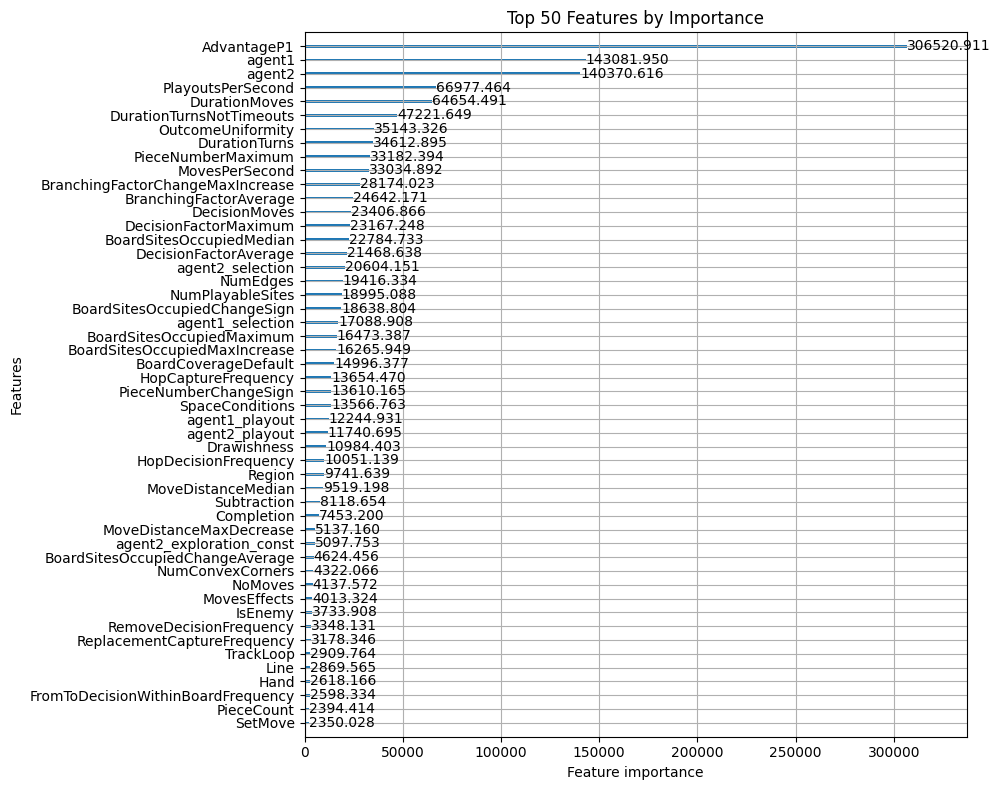

Fold 5 - RMSE: 0.41391893165550947
List of oof scores: [0.4249407799683842, 0.4159430501807028, 0.42153060199955394, 0.4138203641528024, 0.41391893165550947]
Average oof score: 0.4180307455913906


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4264
Score: 0.4339
Score: 0.4156
Score: 0.4328
Score: 0.4002
Average CV1 Score: 0.4218

CV2 OOF Scores:
Score: 0.4097
Score: 0.4037
Score: 0.4262
Score: 0.4336
Score: 0.4193
Average CV2 Score: 0.4185

CV3 OOF Scores:
Score: 0.4249
Score: 0.4159
Score: 0.4215
Score: 0.4138
Score: 0.4139
Average CV3 Score: 0.4180


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

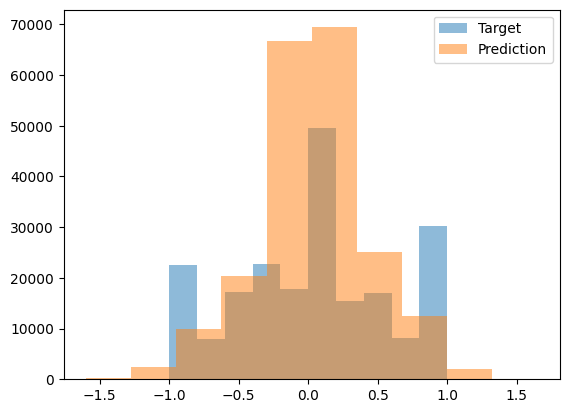

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame,):   
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Average predictions from all models
    predictions = [
        model.predict(test_processed[numerical_cols + categorical_cols]) 
        for model in trained_models
    ]
    predictions = np.mean(predictions, axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.150888       │
│ 233235 ┆ -0.172462      │
│ 233236 ┆ -0.039412      │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
lightgbm_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols, 
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./lightgbm_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(lightgbm_predict, f)

***